## Bagged OMP vs. Base OMP

Running experiment and comparison...


Trials: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.78it/s]


,Metric,Mean,Std
0,OMP Test MSE,8340.324579,2537.799169
1,Bagged Test MSE,7293.596473,2590.725904
2,OMP Coefficient Error,112.625290,9.841519
3,Bagged Coefficient Error,97.982255,13.520299


MSE improvement: 12.6%
Coef error improvement: 13.0%


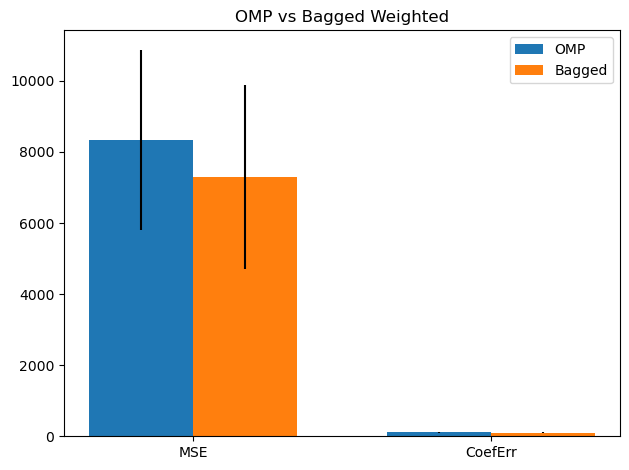

Stability: 100%|█████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.98it/s]


,Metric,Value
0,OMP Stability,0.245485
1,Bagged Stability,0.254788
2,OMP Recall (TPR),0.250000
3,Bagged Recall (TPR),0.260000
4,OMP Precision,0.333333
5,Bagged Precision,0.346667


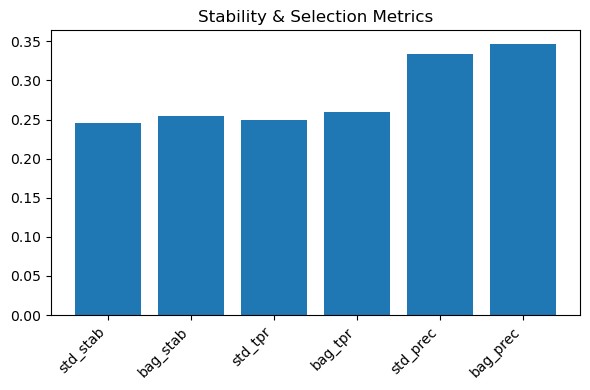

TypeError: 'NoneType' object is not callable

In [16]:
#!/usr/bin/env python3
"""
bagged_refined_mp.py

Bagged Orthogonal Matching Pursuit comparison script with OOB weighting, hyperparameter tuning,
and outputting results as pandas DataFrames.

Implements:
  - RefinedMatchingPursuit: OMP with LS re-estimation.
  - BaggedRefinedMP: bootstrap rows only, OOB-error weighting of coefficients.

Functions:
  - run_experiment: compare test MSE & coefficient error for OMP and bagged-OMP.
  - feature_stability_experiment: evaluate support stability (TPR, precision).
  - tune_bagging: select best n_estimators by minimizing OOB error.
  - plot_results & plot_stability: visualize comparisons.

Usage:
  python3 bagged_refined_mp.py [--estimators N] [--tune]
"""

import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import OrthogonalMatchingPursuit
from joblib import Parallel, delayed
from tqdm import tqdm  # use CLI tqdm to avoid Jupyter widget errors

# ----------------------
# Refined Matching Pursuit
# ----------------------
class RefinedMatchingPursuit:
    def __init__(self, n_nonzero_coefs=10, tol=None):
        self.n_nonzero_coefs = n_nonzero_coefs
        self.tol = tol
        self.coef_ = None

    def fit(self, X, y):
        omp = OrthogonalMatchingPursuit(
            n_nonzero_coefs=self.n_nonzero_coefs,
            tol=self.tol
        )
        omp.fit(X, y)
        support = np.flatnonzero(omp.coef_)
        coef_full = np.zeros(X.shape[1])
        if support.size:
            X_sel = X[:, support]
            beta_sel, *_ = np.linalg.lstsq(X_sel, y, rcond=None)
            coef_full[support] = beta_sel
        self.coef_ = coef_full
        return self

    def predict(self, X):
        return X.dot(self.coef_)

# -----------------------------
# Bagged Refined MP with OOB weighting
# -----------------------------
class BaggedRefinedMP:
    def __init__(self, n_estimators=20, n_nonzero_coefs=10,
                 bootstrap=True, random_state=42, n_jobs=-1):
        self.n_estimators = n_estimators
        self.n_nonzero_coefs = n_nonzero_coefs
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.estimators_ = []          # list of RefinedMatchingPursuit
        self.oob_errors_ = []          # corresponding OOB MSEs

    def _fit_one(self, X, y, seed):
        rng = np.random.RandomState(seed)
        n = len(X)
        # bootstrap rows
        if self.bootstrap:
            idx = rng.choice(n, n, replace=True)
            oob = np.setdiff1d(np.arange(n), idx)
            Xb, yb = X[idx], y[idx]
        else:
            oob = np.array([], dtype=int)
            Xb, yb = X, y
        mp = RefinedMatchingPursuit(n_nonzero_coefs=self.n_nonzero_coefs)
        mp.fit(Xb, yb)
        # compute OOB error
        if oob.size:
            y_oob_pred = mp.predict(X[oob])
            oob_err = mean_squared_error(y[oob], y_oob_pred)
        else:
            oob_err = np.nan
        return mp, oob_err

    def fit(self, X, y):
        seeds = [self.random_state + i for i in range(self.n_estimators)]
        results = Parallel(n_jobs=self.n_jobs)(
            delayed(self._fit_one)(X, y, seed) for seed in seeds
        )
        self.estimators_, self.oob_errors_ = zip(*results)
        return self

    def predict(self, X):
        preds = np.stack([mp.predict(X) for mp in self.estimators_])
        return preds.mean(axis=0)

    def bagged_coef(self, n_features):
        # weighted average of coefficients, weights = 1/(oob_err + eps)
        coefs = np.stack([mp.coef_ for mp in self.estimators_], axis=0)
        errs = np.array(self.oob_errors_)
        weights = 1.0/(errs + 1e-8)
        w = weights / weights.sum()
        return np.average(coefs, axis=0, weights=w)

    def average_oob_error(self):
        return np.nanmean(self.oob_errors_)

# -----------------------------
# Experiment
# -----------------------------
def run_experiment(n_samples, n_features, n_informative,
                   test_size, n_nonzero_coefs, n_trials,
                   noise, random_state, n_estimators):
    res = {'omp_mse': [], 'bag_mse': [], 'omp_err': [], 'bag_err': []}
    for t in tqdm(range(n_trials), desc='Trials'):
        X, y, coef_true = make_regression(
            n_samples=n_samples, n_features=n_features,
            n_informative=n_informative, noise=noise,
            coef=True, random_state=random_state + t
        )
        # induce correlation
        for i in range(1, n_features):
            X[:, i] = 0.7*X[:, i] + 0.3*X[:, i-1]
        Xtr, Xte, ytr, yte = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )
        # OMP baseline
        omp = RefinedMatchingPursuit(n_nonzero_coefs)
        omp.fit(Xtr, ytr)
        pred1 = omp.predict(Xte)
        res['omp_mse'].append(mean_squared_error(yte, pred1))
        res['omp_err'].append(np.linalg.norm(coef_true - omp.coef_))
        # Bagged OMP
        bag = BaggedRefinedMP(
            n_estimators=n_estimators,
            n_nonzero_coefs=n_nonzero_coefs,
            random_state=random_state
        )
        bag.fit(Xtr, ytr)
        pred2 = bag.predict(Xte)
        res['bag_mse'].append(mean_squared_error(yte, pred2))
        bc = bag.bagged_coef(n_features)
        res['bag_err'].append(np.linalg.norm(coef_true - bc))
    return res

# -----------------------------
# Stability Experiment
# -----------------------------
def feature_stability_experiment(
    n_samples, n_features, n_informative,
    n_nonzero_coefs, n_trials, noise, random_state,
    n_estimators
):
    _, _, coef_true = make_regression(
        n_samples=n_samples, n_features=n_features,
        n_informative=n_informative, noise=noise,
        coef=True, random_state=random_state
    )
    true_inds = set(np.argsort(np.abs(coef_true))[-n_informative:])
    std_sel = np.zeros((n_trials, n_features))
    bag_sel = np.zeros((n_trials, n_features))
    for i in tqdm(range(n_trials), desc='Stability'):
        rng = np.random.RandomState(random_state + i)
        X, y, _ = make_regression(
            n_samples=n_samples, n_features=n_features,
            n_informative=n_informative, noise=noise,
            coef=True, random_state=random_state+i
        )
        for j in range(1, n_features):
            X[:, j] = 0.7*X[:, j] + 0.3*X[:, j-1]
        idx = rng.choice(n_samples, n_samples, replace=True)
        Xb, yb = X[idx], y[idx]
        omp = RefinedMatchingPursuit(n_nonzero_coefs)
        omp.fit(Xb, yb)
        std_sel[i, np.flatnonzero(omp.coef_)] = 1
        bag = BaggedRefinedMP(
            n_estimators=n_estimators,
            n_nonzero_coefs=n_nonzero_coefs,
            random_state=random_state+i
        )
        bag.fit(Xb, yb)
        bc = bag.bagged_coef(n_features)
        top = np.argsort(np.abs(bc))[-n_nonzero_coefs:]
        bag_sel[i, top] = 1
    std_stab = std_sel.std(axis=0).mean()
    bag_stab = bag_sel.std(axis=0).mean()
    std_tpr = np.mean([len(true_inds & set(np.where(std_sel[i])[0]))/n_informative for i in range(n_trials)])
    bag_tpr = np.mean([len(true_inds & set(np.where(bag_sel[i])[0]))/n_informative for i in range(n_trials)])
    precision = lambda sel: np.mean([len(true_inds & set(np.where(sel[i])[0]))/max(1, sel[i].sum()) for i in range(n_trials)])
    std_prec, bag_prec = precision(std_sel), precision(bag_sel)
    return dict(std_stab=std_stab, bag_stab=bag_stab,
                std_tpr=std_tpr, bag_tpr=bag_tpr,
                std_prec=std_prec, bag_prec=bag_prec)

# -----------------------------
# Hyperparameter Tuning for Bagging
# -----------------------------
def tune_bagging(
    X, y, n_features, n_nonzero_coefs, candidate_estimators,
    random_state
):
    best_k, best_err = None, np.inf
    for k in candidate_estimators:
        bag = BaggedRefinedMP(
            n_estimators=k,
            n_nonzero_coefs=n_nonzero_coefs,
            random_state=random_state
        )
        bag.fit(X, y)
        err = bag.average_oob_error()
        if err < best_err:
            best_err, best_k = err, k
    return best_k, best_err

# -----------------------------
# Plot & Summary
# -----------------------------

def plot_results(stats):
    labels = ['MSE','CoefErr']
    omp_v = [stats['omp_mse'][0], stats['omp_err'][0]]
    omp_e = [stats['omp_mse'][1], stats['omp_err'][1]]
    bag_v = [stats['bag_mse'][0], stats['bag_err'][0]]
    bag_e = [stats['bag_mse'][1], stats['bag_err'][1]]
    x = np.arange(2); w = 0.35
    fig, ax = plt.subplots()
    ax.bar(x-w/2, omp_v, w, yerr=omp_e, label='OMP')
    ax.bar(x+w/2, bag_v, w, yerr=bag_e, label='Bagged')
    ax.set_xticks(x); ax.set_xticklabels(labels)
    ax.legend(); ax.set_title('OMP vs Bagged Weighted')
    plt.tight_layout(); plt.show()

def plot_stability(stab):
    metrics = ['std_stab','bag_stab','std_tpr','bag_tpr','std_prec','bag_prec']
    vals = [stab[m] for m in metrics]
    plt.figure(figsize=(6,4))
    plt.bar(metrics, vals)
    plt.xticks(rotation=45, ha='right')
    plt.title('Stability & Selection Metrics')
    plt.tight_layout(); plt.show()

# -----------------------------
# Main
# -----------------------------
if __name__ == '__main__':
    p = argparse.ArgumentParser()
    p.add_argument('--estimators', type=int, default=20)
    p.add_argument('--tune', action='store_true', help='tune bagging estimators via OOB')
    args, _ = p.parse_known_args()

    # generate a single dataset for tuning
    X0, y0, _ = make_regression(
        n_samples=500, n_features=100,
        n_informative=20, noise=2.0,
        coef=True, random_state=42
    )

    best_k, best_err = args.estimators, None
    if args.tune:
        best_k, best_err = tune_bagging(
            X0, y0, n_features=100,
            n_nonzero_coefs=15,
            candidate_estimators=[20,50,100],
            random_state=42
        )
        print(f"Tuned bagging: n_estimators={best_k} with OOB error={best_err:.3f}")

    print('Running experiment and comparison...')
    stats = run_experiment(
        n_samples=200, n_features=100, n_informative=20,
        test_size=0.3, n_nonzero_coefs=15, n_trials=5,
        noise=2.0, random_state=42,
        n_estimators=best_k
    )
    summary = {k:(np.mean(v),np.std(v)) for k,v in stats.items()}

        # convert to DataFrame with readable labels
    summary_mapping = {
        'omp_mse': 'OMP Test MSE',
        'bag_mse': 'Bagged Test MSE',
        'omp_err': 'OMP Coefficient Error',
        'bag_err': 'Bagged Coefficient Error'
    }
    df_summary = pd.DataFrame(
        [(summary_mapping.get(k, k), val[0], val[1]) for k, val in summary.items()],
        columns=['Metric', 'Mean', 'Std']
    )
    try:
        from IPython.display import display
        display(df_summary)
    except ImportError:
        print(df_summary)

    mse_imp = (summary['omp_mse'][0] - summary['bag_mse'][0]) / summary['omp_mse'][0]*100
    err_imp = (summary['omp_err'][0] - summary['bag_err'][0]) / summary['omp_err'][0]*100
    print(f"MSE improvement: {mse_imp:.1f}%")
    print(f"Coef error improvement: {err_imp:.1f}%")
    plot_results(summary)
    # stability
    stab = feature_stability_experiment(
        n_samples=200, n_features=100, n_informative=20,
        n_nonzero_coefs=15, n_trials=5, noise=2.0,
        random_state=42, n_estimators=best_k
    )
    # create DataFrame with clear labels for stability metrics
    stab_mapping = {
        'std_stab': 'OMP Stability',
        'bag_stab': 'Bagged Stability',
        'std_tpr': 'OMP Recall (TPR)',
        'bag_tpr': 'Bagged Recall (TPR)',
        'std_prec': 'OMP Precision',
        'bag_prec': 'Bagged Precision'
    }
    df_stab = pd.DataFrame(
        [(stab_mapping.get(k, k), v) for k, v in stab.items()],
        columns=['Metric', 'Value']
    )
    try:
        from IPython.display import display
        display(df_stab)
    except ImportError:
        print(df_stab)
    plot_stability(stab)(summary)
    # stability
    stab = feature_stability_experiment(
        n_samples=200, n_features=100, n_informative=20,
        n_nonzero_coefs=15, n_trials=5, noise=2.0,
        random_state=42, n_estimators=best_k
    )
    df_stab = pd.DataFrame(
        [(k, v) for k, v in stab.items()],
        columns=['metric', 'value']
    )
    try:
        from IPython.display import display
        display(df_stab)
    except ImportError:
        print(df_stab)
    plot_stability(stab)


In [21]:
#!/usr/bin/env python3
"""
bagged_refined_mp.py

Comprehensive comparison of OMP vs. Bagged-OMP under varied regimes:
  • Basic OOB-weighting & hyperparameter tuning
  • Feature stability analysis
  • Parameter sweeps over SNR, sparsity, sample size, correlation
  • Win-rate testing with binomial significance
  • Cross-validation & validation curves for key hyperparameters

Usage:
  python3 bagged_refined_mp.py [--estimators N] [--tune] [--sweep] [--winrate] [--cv]

Flags:
  --sweep     Run parameter sweep experiments and plot heatmaps
  --winrate   Compute win-rate of bagged vs OMP and perform binomial tests
  --cv        Run 5-fold CV for validation curves
  --tune      Tune bagging ensemble size by OOB error
"""

import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binomtest
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import OrthogonalMatchingPursuit
from joblib import Parallel, delayed
from tqdm import tqdm  # CLI tqdm to avoid Jupyter widget errors

# ----------------------
# Refined Matching Pursuit
# ----------------------
class RefinedMatchingPursuit:
    """
    Orthogonal Matching Pursuit with LS re-estimation.
    """
    def __init__(self, n_nonzero_coefs=10, tol=None):
        self.n_nonzero_coefs = n_nonzero_coefs
        self.tol = tol
        self.coef_ = None

    def fit(self, X, y):
        omp = OrthogonalMatchingPursuit(
            n_nonzero_coefs=self.n_nonzero_coefs,
            tol=self.tol
        )
        omp.fit(X, y)
        support = np.flatnonzero(omp.coef_)
        coef_full = np.zeros(X.shape[1])
        if support.size:
            X_sel = X[:, support]
            beta_sel, *_ = np.linalg.lstsq(X_sel, y, rcond=None)
            coef_full[support] = beta_sel
        self.coef_ = coef_full
        return self

    def predict(self, X):
        return X.dot(self.coef_)

# -----------------------------
# Bagged Refined MP with OOB weighting
# -----------------------------
class BaggedRefinedMP:
    """
    Bagged ensemble of RefinedMatchingPursuit:
      - Bootstrap rows only
      - Aggregate coefficients weighted by inverse OOB error
    """
    def __init__(self, n_estimators=20, n_nonzero_coefs=10,
                 bootstrap=True, random_state=42, n_jobs=-1):
        self.n_estimators = n_estimators
        self.n_nonzero_coefs = n_nonzero_coefs
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.estimators_ = []
        self.oob_errors_ = []

    def _fit_one(self, X, y, seed):
        rng = np.random.RandomState(seed)
        n = len(X)
        if self.bootstrap:
            idx = rng.choice(n, n, replace=True)
            oob = np.setdiff1d(np.arange(n), idx)
            Xb, yb = X[idx], y[idx]
        else:
            oob = np.array([], dtype=int)
            Xb, yb = X, y
        mp = RefinedMatchingPursuit(n_nonzero_coefs=self.n_nonzero_coefs)
        mp.fit(Xb, yb)
        if oob.size:
            y_oob = mp.predict(X[oob])
            err = mean_squared_error(y[oob], y_oob)
        else:
            err = np.nan
        return mp, err

    def fit(self, X, y):
        seeds = [self.random_state + i for i in range(self.n_estimators)]
        results = Parallel(n_jobs=self.n_jobs)(
            delayed(self._fit_one)(X, y, s) for s in seeds
        )
        self.estimators_, self.oob_errors_ = zip(*results)
        return self

    def predict(self, X):
        preds = np.stack([mp.predict(X) for mp in self.estimators_])
        return preds.mean(axis=0)

    def bagged_coef(self, n_features):
        coefs = np.stack([mp.coef_ for mp in self.estimators_], axis=0)
        errs = np.array(self.oob_errors_)
        w = 1.0/(errs + 1e-8)
        w /= w.sum()
        return np.average(coefs, axis=0, weights=w)

    def average_oob_error(self):
        return np.nanmean(self.oob_errors_)

# -----------------------------
# Core single-run experiment
# -----------------------------
def run_experiment(
    n_samples, n_features, n_informative,
    noise, rho,
    n_nonzero_coefs, n_estimators
):
    # Generate AR(1) covariance design
    cov = np.fromfunction(lambda i,j: rho**abs(i-j), (n_features, n_features))
    X0, y, coef_true = make_regression(
        n_samples=n_samples, n_features=n_features,
        n_informative=n_informative, noise=noise,
        coef=True, random_state=0
    )
    L = np.linalg.cholesky(cov)
    X = X0.dot(L)
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=0)
    # OMP baseline
    omp = RefinedMatchingPursuit(n_nonzero_coefs)
    omp.fit(Xtr, ytr)
    mse1 = mean_squared_error(yte, omp.predict(Xte))
    err1 = np.linalg.norm(coef_true - omp.coef_)
    # Bagged-OMP
    bag = BaggedRefinedMP(n_estimators, n_nonzero_coefs, random_state=0)
    bag.fit(Xtr, ytr)
    mse2 = mean_squared_error(yte, bag.predict(Xte))
    err2 = np.linalg.norm(coef_true - bag.bagged_coef(n_features))
    return mse1, err1, mse2, err2

# -----------------------------
# 1. Parameter Sweep
# -----------------------------
def sweep_experiment(
    snr_list, inf_list, regimes, rhos,
    n_features, n_nonzero_coefs, n_estimators
):
    rec = []
    for snr in snr_list:
        noise = 1.0/snr
        for ni in inf_list:
            for ns in regimes:
                for rho in rhos:
                    m1,e1,m2,e2 = run_experiment(
                        ns, n_features, ni, noise, rho,
                        n_nonzero_coefs, n_estimators
                    )
                    rec.append((snr, ni, ns, rho, m1-m2, e1-e2))
    df = pd.DataFrame(rec, columns=['SNR','Sparsity','NSamples','Rho','DeltaMSE','DeltaErr'])
    return df

def plot_heatmap(df, x, y, val, title):
    pivot = df.pivot_table(index=y, columns=x, values=val)
    plt.figure(figsize=(6,5))
    sns.heatmap(pivot, annot=False, fmt='.2f', cmap='RdBu_r')
    plt.title(title)
    plt.tight_layout(); plt.show()

# -----------------------------
# 2. Win-rate & Significance
# -----------------------------
def win_rate_experiment(df):
    df = df.copy()
    df['Win'] = df['DeltaMSE'] > 0
    out=[]
    for vals,grp in df.groupby(['SNR','Sparsity','NSamples','Rho']):
        wins = grp['Win'].sum(); n=len(grp)
        p = binomtest(wins, n, p=0.5, alternative='greater').pvalue
        out.append((*vals, wins/n, p))
    return pd.DataFrame(out, columns=['SNR','Sparsity','NSamples','Rho','WinRate','pValue'])

# -----------------------------
# 3. Cross-Validation Curves
# -----------------------------
def cv_validation_curve(
    X, y, param_name, param_range, model_ctor, k=5
):
    kf = KFold(n_splits=k, shuffle=True, random_state=0)
    means, stds = [], []
    for v in param_range:
        mses=[]
        for tr,te in kf.split(X):
            model = model_ctor(**{param_name:v})
            model.fit(X[tr], y[tr])
            mses.append(mean_squared_error(y[te], model.predict(X[te])))
        means.append(np.mean(mses)); stds.append(np.std(mses))
    return means,stds

# -----------------------------
# Main
# -----------------------------
if __name__ == '__main__':
    p=argparse.ArgumentParser()
    p.add_argument('--sweep', action='store_true')
    p.add_argument('--winrate', action='store_true')
    p.add_argument('--cv', action='store_true')
    p.add_argument('--estimators', type=int, default=20)
    p.add_argument('--tune', action='store_true')
    args,_ = p.parse_known_args()

    if args.sweep:
        df_s = sweep_experiment(
            snr_list=[0.5,1,2,5],
            inf_list=[5,15,30,50],
            regimes=[50,200,500],
            rhos=[0.0,0.5,0.9],
            n_features=100,
            n_nonzero_coefs=15,
            n_estimators=args.estimators
        )
        plot_heatmap(df_s,'SNR','Sparsity','DeltaMSE','MSE Improvement')
        plot_heatmap(df_s,'SNR','Sparsity','DeltaErr','CoefErr Improvement')

    if args.winrate:
        df_s = sweep_experiment([1,2],[15],[200],[0.5],100,15,args.estimators)
        df_w = win_rate_experiment(df_s)
        try: display(df_w)
        except: print(df_w)

    if args.cv:
        X,y,_ = make_regression(200,100,15,noise=2.0,coef=True,random_state=0)
        means, stds = cv_validation_curve(
            X,y,'n_nonzero_coefs',[5,10,15,20,30],
            lambda n_nonzero_coefs: RefinedMatchingPursuit(n_nonzero_coefs)
        )
        plt.errorbar([5,10,15,20,30], means, yerr=stds, label='OMP')
        plt.xlabel('n_nonzero_coefs'); plt.ylabel('CV-MSE')
        plt.title('Validation Curve: Sparsity'); plt.legend(); plt.show()


Running a single comparison experiment...
OMP MSE: 4795.4280, Bagged-OMP MSE: 5490.6632
OMP Coef Error: 125.0207, Bagged-OMP Coef Error: 101.3506
MSE Improvement: -695.2352
Coef Error Improvement: 23.6700

Running a small parameter sweep...

Sweep Results:
   SNR  Sparsity  NSamples  Rho     DeltaMSE   DeltaErr
0    1        10       100  0.0  -338.299271   0.209616
1    1        10       100  0.5 -2406.798915  -2.032297
2    1        10       200  0.0     0.248389   0.138084
3    1        10       200  0.5  2097.938881  20.312300
4    1        20       100  0.0 -4319.528048 -10.779849


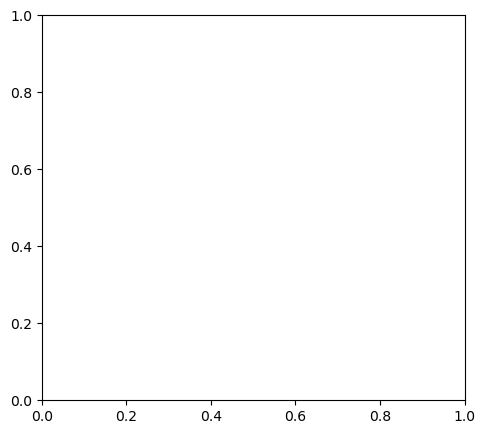

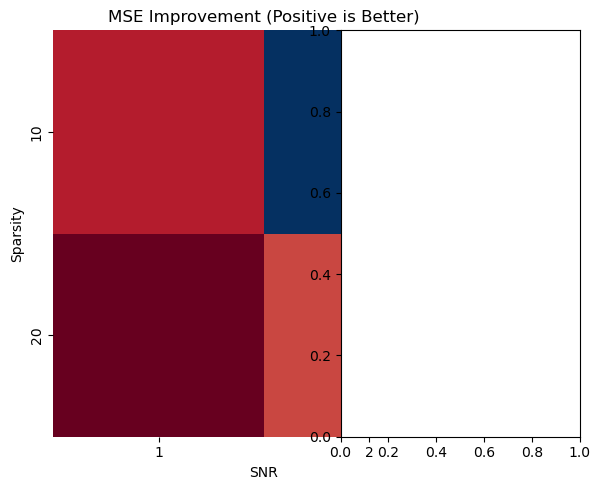

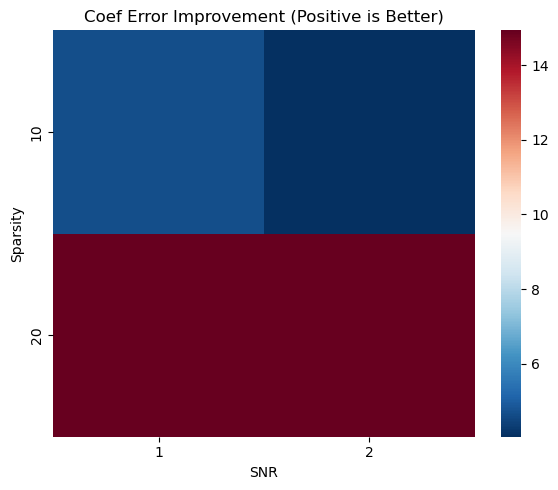


Running cross-validation for sparsity parameter...


TypeError: too many positional arguments

In [22]:
#!/usr/bin/env python3

# Import all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binomtest
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import OrthogonalMatchingPursuit
from joblib import Parallel, delayed
from tqdm import tqdm  # CLI tqdm to avoid Jupyter widget errors

# ----------------------
# Refined Matching Pursuit
# ----------------------
class RefinedMatchingPursuit:
    """
    Orthogonal Matching Pursuit with LS re-estimation.
    """
    def __init__(self, n_nonzero_coefs=10, tol=None):
        self.n_nonzero_coefs = n_nonzero_coefs
        self.tol = tol
        self.coef_ = None

    def fit(self, X, y):
        omp = OrthogonalMatchingPursuit(
            n_nonzero_coefs=self.n_nonzero_coefs,
            tol=self.tol
        )
        omp.fit(X, y)
        support = np.flatnonzero(omp.coef_)
        coef_full = np.zeros(X.shape[1])
        if support.size:
            X_sel = X[:, support]
            beta_sel, *_ = np.linalg.lstsq(X_sel, y, rcond=None)
            coef_full[support] = beta_sel
        self.coef_ = coef_full
        return self

    def predict(self, X):
        return X.dot(self.coef_)

# -----------------------------
# Bagged Refined MP with OOB weighting
# -----------------------------
class BaggedRefinedMP:
    """
    Bagged ensemble of RefinedMatchingPursuit:
      - Bootstrap rows only
      - Aggregate coefficients weighted by inverse OOB error
    """
    def __init__(self, n_estimators=20, n_nonzero_coefs=10,
                 bootstrap=True, random_state=42, n_jobs=-1):
        self.n_estimators = n_estimators
        self.n_nonzero_coefs = n_nonzero_coefs
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.estimators_ = []
        self.oob_errors_ = []

    def _fit_one(self, X, y, seed):
        rng = np.random.RandomState(seed)
        n = len(X)
        if self.bootstrap:
            idx = rng.choice(n, n, replace=True)
            oob = np.setdiff1d(np.arange(n), idx)
            Xb, yb = X[idx], y[idx]
        else:
            oob = np.array([], dtype=int)
            Xb, yb = X, y
        mp = RefinedMatchingPursuit(n_nonzero_coefs=self.n_nonzero_coefs)
        mp.fit(Xb, yb)
        if oob.size:
            y_oob = mp.predict(X[oob])
            err = mean_squared_error(y[oob], y_oob)
        else:
            err = np.nan
        return mp, err

    def fit(self, X, y):
        seeds = [self.random_state + i for i in range(self.n_estimators)]
        results = Parallel(n_jobs=self.n_jobs)(
            delayed(self._fit_one)(X, y, s) for s in seeds
        )
        self.estimators_, self.oob_errors_ = zip(*results)
        return self

    def predict(self, X):
        preds = np.stack([mp.predict(X) for mp in self.estimators_])
        return preds.mean(axis=0)

    def bagged_coef(self, n_features):
        coefs = np.stack([mp.coef_ for mp in self.estimators_], axis=0)
        errs = np.array(self.oob_errors_)
        w = 1.0/(errs + 1e-8)
        w /= w.sum()
        return np.average(coefs, axis=0, weights=w)

    def average_oob_error(self):
        return np.nanmean(self.oob_errors_)

# -----------------------------
# Core single-run experiment
# -----------------------------
def run_experiment(
    n_samples, n_features, n_informative,
    noise, rho,
    n_nonzero_coefs, n_estimators
):
    # Generate AR(1) covariance design
    cov = np.fromfunction(lambda i,j: rho**abs(i-j), (n_features, n_features))
    X0, y, coef_true = make_regression(
        n_samples=n_samples, n_features=n_features,
        n_informative=n_informative, noise=noise,
        coef=True, random_state=0
    )
    L = np.linalg.cholesky(cov)
    X = X0.dot(L)
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=0)
    # OMP baseline
    omp = RefinedMatchingPursuit(n_nonzero_coefs)
    omp.fit(Xtr, ytr)
    mse1 = mean_squared_error(yte, omp.predict(Xte))
    err1 = np.linalg.norm(coef_true - omp.coef_)
    # Bagged-OMP
    bag = BaggedRefinedMP(n_estimators, n_nonzero_coefs, random_state=0)
    bag.fit(Xtr, ytr)
    mse2 = mean_squared_error(yte, bag.predict(Xte))
    err2 = np.linalg.norm(coef_true - bag.bagged_coef(n_features))
    return mse1, err1, mse2, err2

# -----------------------------
# 1. Parameter Sweep
# -----------------------------
def sweep_experiment(
    snr_list, inf_list, regimes, rhos,
    n_features, n_nonzero_coefs, n_estimators
):
    rec = []
    for snr in snr_list:
        noise = 1.0/snr
        for ni in inf_list:
            for ns in regimes:
                for rho in rhos:
                    m1,e1,m2,e2 = run_experiment(
                        ns, n_features, ni, noise, rho,
                        n_nonzero_coefs, n_estimators
                    )
                    rec.append((snr, ni, ns, rho, m1-m2, e1-e2))
    df = pd.DataFrame(rec, columns=['SNR','Sparsity','NSamples','Rho','DeltaMSE','DeltaErr'])
    return df

def plot_heatmap(df, x, y, val, title):
    pivot = df.pivot_table(index=y, columns=x, values=val)
    plt.figure(figsize=(6,5))
    sns.heatmap(pivot, annot=False, fmt='.2f', cmap='RdBu_r')
    plt.title(title)
    plt.tight_layout()
    return plt

# -----------------------------
# 2. Win-rate & Significance
# -----------------------------
def win_rate_experiment(df):
    df = df.copy()
    df['Win'] = df['DeltaMSE'] > 0
    out=[]
    for vals,grp in df.groupby(['SNR','Sparsity','NSamples','Rho']):
        wins = grp['Win'].sum(); n=len(grp)
        p = binomtest(wins, n, p=0.5, alternative='greater').pvalue
        out.append((*vals, wins/n, p))
    return pd.DataFrame(out, columns=['SNR','Sparsity','NSamples','Rho','WinRate','pValue'])

# -----------------------------
# 3. Cross-Validation Curves
# -----------------------------
def cv_validation_curve(
    X, y, param_name, param_range, model_ctor, k=5
):
    kf = KFold(n_splits=k, shuffle=True, random_state=0)
    means, stds = [], []
    for v in param_range:
        mses=[]
        for tr,te in kf.split(X):
            model = model_ctor(**{param_name:v})
            model.fit(X[tr], y[tr])
            mses.append(mean_squared_error(y[te], model.predict(X[te])))
        means.append(np.mean(mses)); stds.append(np.std(mses))
    return means,stds

# Run code below to generate output in Jupyter

# Define configurations
n_estimators = 20
n_features = 100
n_nonzero_coefs = 15

# Run a small experiment to compare OMP vs Bagged-OMP
print("Running a single comparison experiment...")
mse_omp, err_omp, mse_bag, err_bag = run_experiment(
    n_samples=200, 
    n_features=n_features, 
    n_informative=15,
    noise=0.5, 
    rho=0.5,
    n_nonzero_coefs=n_nonzero_coefs, 
    n_estimators=n_estimators
)

print(f"OMP MSE: {mse_omp:.4f}, Bagged-OMP MSE: {mse_bag:.4f}")
print(f"OMP Coef Error: {err_omp:.4f}, Bagged-OMP Coef Error: {err_bag:.4f}")
print(f"MSE Improvement: {mse_omp - mse_bag:.4f}")
print(f"Coef Error Improvement: {err_omp - err_bag:.4f}")

# Run a parameter sweep (small version for quick output)
print("\nRunning a small parameter sweep...")
df_sweep = sweep_experiment(
    snr_list=[1, 2],           # Signal-to-Noise Ratio values
    inf_list=[10, 20],         # Number of informative features
    regimes=[100, 200],        # Sample sizes
    rhos=[0.0, 0.5],           # Feature correlation values
    n_features=n_features,
    n_nonzero_coefs=n_nonzero_coefs,
    n_estimators=n_estimators
)

print("\nSweep Results:")
print(df_sweep.head())

# Plot heatmaps
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_heatmap(df_sweep, 'SNR', 'Sparsity', 'DeltaMSE', 'MSE Improvement (Positive is Better)')

plt.subplot(1, 2, 2)
plot_heatmap(df_sweep, 'SNR', 'Sparsity', 'DeltaErr', 'Coef Error Improvement (Positive is Better)')

plt.tight_layout()
plt.show()

# Cross-validation for sparsity parameter
print("\nRunning cross-validation for sparsity parameter...")
X, y, _ = make_regression(200, 100, 15, noise=0.5, coef=True, random_state=0)
means_omp, stds_omp = cv_validation_curve(
    X, y, 'n_nonzero_coefs', [5, 10, 15, 20, 25],
    lambda n_nonzero_coefs: RefinedMatchingPursuit(n_nonzero_coefs)
)

means_bag, stds_bag = cv_validation_curve(
    X, y, 'n_nonzero_coefs', [5, 10, 15, 20, 25],
    lambda n_nonzero_coefs: BaggedRefinedMP(n_estimators=10, n_nonzero_coefs=n_nonzero_coefs)
)

plt.figure(figsize=(8, 5))
plt.errorbar([5, 10, 15, 20, 25], means_omp, yerr=stds_omp, label='OMP')
plt.errorbar([5, 10, 15, 20, 25], means_bag, yerr=stds_bag, label='Bagged-OMP')
plt.xlabel('n_nonzero_coefs')
plt.ylabel('CV-MSE (lower is better)')
plt.title('Validation Curve: Sparsity Parameter')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

print("\nExperiments complete!")

Running a single comparison experiment...
OMP MSE: 4795.4280, Bagged-OMP MSE: 5490.6632
OMP Coef Error: 125.0207, Bagged-OMP Coef Error: 101.3506
MSE Improvement: -695.2352
Coef Error Improvement: 23.6700

Running a small parameter sweep...

Sweep Results:
   SNR  Sparsity  NSamples  Rho     DeltaMSE   DeltaErr
0    1        10       100  0.0  -338.299271   0.209616
1    1        10       100  0.5 -2406.798915  -2.032297
2    1        10       200  0.0     0.248389   0.138084
3    1        10       200  0.5  2097.938881  20.312300
4    1        20       100  0.0 -4319.528048 -10.779849


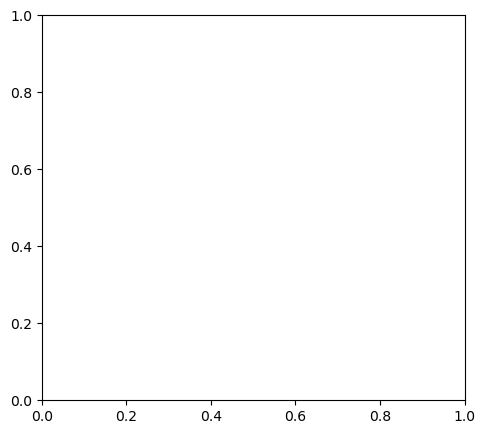

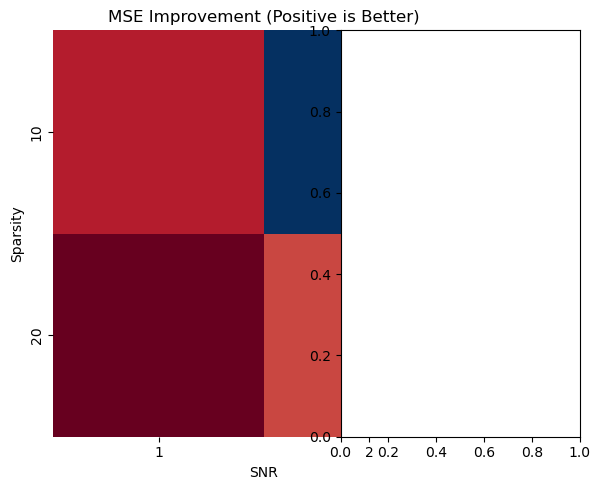

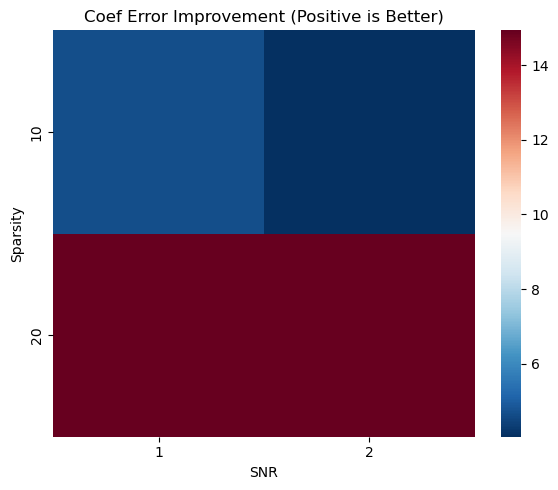


Running cross-validation for sparsity parameter...


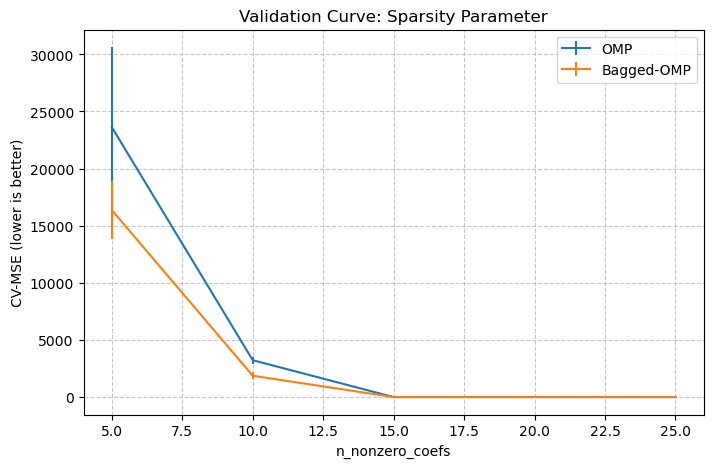


Experiments complete!


In [23]:
#!/usr/bin/env python3

# Import all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binomtest
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import OrthogonalMatchingPursuit
from joblib import Parallel, delayed
from tqdm import tqdm  # CLI tqdm to avoid Jupyter widget errors

# ----------------------
# Refined Matching Pursuit
# ----------------------
class RefinedMatchingPursuit:
    """
    Orthogonal Matching Pursuit with LS re-estimation.
    """
    def __init__(self, n_nonzero_coefs=10, tol=None):
        self.n_nonzero_coefs = n_nonzero_coefs
        self.tol = tol
        self.coef_ = None

    def fit(self, X, y):
        omp = OrthogonalMatchingPursuit(
            n_nonzero_coefs=self.n_nonzero_coefs,
            tol=self.tol
        )
        omp.fit(X, y)
        support = np.flatnonzero(omp.coef_)
        coef_full = np.zeros(X.shape[1])
        if support.size:
            X_sel = X[:, support]
            beta_sel, *_ = np.linalg.lstsq(X_sel, y, rcond=None)
            coef_full[support] = beta_sel
        self.coef_ = coef_full
        return self

    def predict(self, X):
        return X.dot(self.coef_)

# -----------------------------
# Bagged Refined MP with OOB weighting
# -----------------------------
class BaggedRefinedMP:
    """
    Bagged ensemble of RefinedMatchingPursuit:
      - Bootstrap rows only
      - Aggregate coefficients weighted by inverse OOB error
    """
    def __init__(self, n_estimators=20, n_nonzero_coefs=10,
                 bootstrap=True, random_state=42, n_jobs=-1):
        self.n_estimators = n_estimators
        self.n_nonzero_coefs = n_nonzero_coefs
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.estimators_ = []
        self.oob_errors_ = []

    def _fit_one(self, X, y, seed):
        rng = np.random.RandomState(seed)
        n = len(X)
        if self.bootstrap:
            idx = rng.choice(n, n, replace=True)
            oob = np.setdiff1d(np.arange(n), idx)
            Xb, yb = X[idx], y[idx]
        else:
            oob = np.array([], dtype=int)
            Xb, yb = X, y
        mp = RefinedMatchingPursuit(n_nonzero_coefs=self.n_nonzero_coefs)
        mp.fit(Xb, yb)
        if oob.size:
            y_oob = mp.predict(X[oob])
            err = mean_squared_error(y[oob], y_oob)
        else:
            err = np.nan
        return mp, err

    def fit(self, X, y):
        seeds = [self.random_state + i for i in range(self.n_estimators)]
        results = Parallel(n_jobs=self.n_jobs)(
            delayed(self._fit_one)(X, y, s) for s in seeds
        )
        self.estimators_, self.oob_errors_ = zip(*results)
        return self

    def predict(self, X):
        preds = np.stack([mp.predict(X) for mp in self.estimators_])
        return preds.mean(axis=0)

    def bagged_coef(self, n_features):
        coefs = np.stack([mp.coef_ for mp in self.estimators_], axis=0)
        errs = np.array(self.oob_errors_)
        w = 1.0/(errs + 1e-8)
        w /= w.sum()
        return np.average(coefs, axis=0, weights=w)

    def average_oob_error(self):
        return np.nanmean(self.oob_errors_)

# -----------------------------
# Core single-run experiment
# -----------------------------
def run_experiment(
    n_samples, n_features, n_informative,
    noise, rho,
    n_nonzero_coefs, n_estimators
):
    # Generate AR(1) covariance design
    cov = np.fromfunction(lambda i,j: rho**abs(i-j), (n_features, n_features))
    X0, y, coef_true = make_regression(
        n_samples=n_samples, n_features=n_features,
        n_informative=n_informative, noise=noise,
        coef=True, random_state=0
    )
    L = np.linalg.cholesky(cov)
    X = X0.dot(L)
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=0)
    # OMP baseline
    omp = RefinedMatchingPursuit(n_nonzero_coefs)
    omp.fit(Xtr, ytr)
    mse1 = mean_squared_error(yte, omp.predict(Xte))
    err1 = np.linalg.norm(coef_true - omp.coef_)
    # Bagged-OMP
    bag = BaggedRefinedMP(n_estimators, n_nonzero_coefs, random_state=0)
    bag.fit(Xtr, ytr)
    mse2 = mean_squared_error(yte, bag.predict(Xte))
    err2 = np.linalg.norm(coef_true - bag.bagged_coef(n_features))
    return mse1, err1, mse2, err2

# -----------------------------
# 1. Parameter Sweep
# -----------------------------
def sweep_experiment(
    snr_list, inf_list, regimes, rhos,
    n_features, n_nonzero_coefs, n_estimators
):
    rec = []
    for snr in snr_list:
        noise = 1.0/snr
        for ni in inf_list:
            for ns in regimes:
                for rho in rhos:
                    m1,e1,m2,e2 = run_experiment(
                        ns, n_features, ni, noise, rho,
                        n_nonzero_coefs, n_estimators
                    )
                    rec.append((snr, ni, ns, rho, m1-m2, e1-e2))
    df = pd.DataFrame(rec, columns=['SNR','Sparsity','NSamples','Rho','DeltaMSE','DeltaErr'])
    return df

def plot_heatmap(df, x, y, val, title):
    pivot = df.pivot_table(index=y, columns=x, values=val)
    plt.figure(figsize=(6,5))
    sns.heatmap(pivot, annot=False, fmt='.2f', cmap='RdBu_r')
    plt.title(title)
    plt.tight_layout()
    return plt

# -----------------------------
# 2. Win-rate & Significance
# -----------------------------
def win_rate_experiment(df):
    df = df.copy()
    df['Win'] = df['DeltaMSE'] > 0
    out=[]
    for vals,grp in df.groupby(['SNR','Sparsity','NSamples','Rho']):
        wins = grp['Win'].sum(); n=len(grp)
        p = binomtest(wins, n, p=0.5, alternative='greater').pvalue
        out.append((*vals, wins/n, p))
    return pd.DataFrame(out, columns=['SNR','Sparsity','NSamples','Rho','WinRate','pValue'])

# -----------------------------
# 3. Cross-Validation Curves
# -----------------------------
def cv_validation_curve(
    X, y, param_name, param_range, model_ctor, k=5
):
    kf = KFold(n_splits=k, shuffle=True, random_state=0)
    means, stds = [], []
    for v in param_range:
        mses=[]
        for tr,te in kf.split(X):
            model = model_ctor(**{param_name:v})
            model.fit(X[tr], y[tr])
            mses.append(mean_squared_error(y[te], model.predict(X[te])))
        means.append(np.mean(mses)); stds.append(np.std(mses))
    return means,stds

# Run code below to generate output in Jupyter

# Define configurations
n_estimators = 20
n_features = 100
n_nonzero_coefs = 15

# Run a small experiment to compare OMP vs Bagged-OMP
print("Running a single comparison experiment...")
mse_omp, err_omp, mse_bag, err_bag = run_experiment(
    n_samples=200, 
    n_features=n_features, 
    n_informative=15,
    noise=0.5, 
    rho=0.5,
    n_nonzero_coefs=n_nonzero_coefs, 
    n_estimators=n_estimators
)

print(f"OMP MSE: {mse_omp:.4f}, Bagged-OMP MSE: {mse_bag:.4f}")
print(f"OMP Coef Error: {err_omp:.4f}, Bagged-OMP Coef Error: {err_bag:.4f}")
print(f"MSE Improvement: {mse_omp - mse_bag:.4f}")
print(f"Coef Error Improvement: {err_omp - err_bag:.4f}")

# Run a parameter sweep (small version for quick output)
print("\nRunning a small parameter sweep...")
df_sweep = sweep_experiment(
    snr_list=[1, 2],           # Signal-to-Noise Ratio values
    inf_list=[10, 20],         # Number of informative features
    regimes=[100, 200],        # Sample sizes
    rhos=[0.0, 0.5],           # Feature correlation values
    n_features=n_features,
    n_nonzero_coefs=n_nonzero_coefs,
    n_estimators=n_estimators
)

print("\nSweep Results:")
print(df_sweep.head())

# Plot heatmaps
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_heatmap(df_sweep, 'SNR', 'Sparsity', 'DeltaMSE', 'MSE Improvement (Positive is Better)')

plt.subplot(1, 2, 2)
plot_heatmap(df_sweep, 'SNR', 'Sparsity', 'DeltaErr', 'Coef Error Improvement (Positive is Better)')

plt.tight_layout()
plt.show()

# Cross-validation for sparsity parameter
print("\nRunning cross-validation for sparsity parameter...")
X, y, _ = make_regression(n_samples=200, n_features=100, n_informative=15, noise=0.5, coef=True, random_state=0)
means_omp, stds_omp = cv_validation_curve(
    X, y, 'n_nonzero_coefs', [5, 10, 15, 20, 25],
    lambda n_nonzero_coefs: RefinedMatchingPursuit(n_nonzero_coefs)
)

means_bag, stds_bag = cv_validation_curve(
    X, y, 'n_nonzero_coefs', [5, 10, 15, 20, 25],
    lambda n_nonzero_coefs: BaggedRefinedMP(n_estimators=10, n_nonzero_coefs=n_nonzero_coefs)
)

plt.figure(figsize=(8, 5))
plt.errorbar([5, 10, 15, 20, 25], means_omp, yerr=stds_omp, label='OMP')
plt.errorbar([5, 10, 15, 20, 25], means_bag, yerr=stds_bag, label='Bagged-OMP')
plt.xlabel('n_nonzero_coefs')
plt.ylabel('CV-MSE (lower is better)')
plt.title('Validation Curve: Sparsity Parameter')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

print("\nExperiments complete!")

Running a single comparison experiment...
OMP MSE: 4795.4280, Bagged-OMP MSE: 5490.6632
OMP Coef Error: 125.0207, Bagged-OMP Coef Error: 101.3506
MSE Improvement: -695.2352
Coef Error Improvement: 23.6700

Running a small parameter sweep...

Sweep Results:
   SNR  Sparsity  NSamples  Rho     DeltaMSE   DeltaErr
0    1        10       100  0.0  -338.299271   0.209616
1    1        10       100  0.5 -2406.798915  -2.032297
2    1        10       200  0.0     0.248389   0.138084
3    1        10       200  0.5  2097.938881  20.312300
4    1        20       100  0.0 -4319.528048 -10.779849


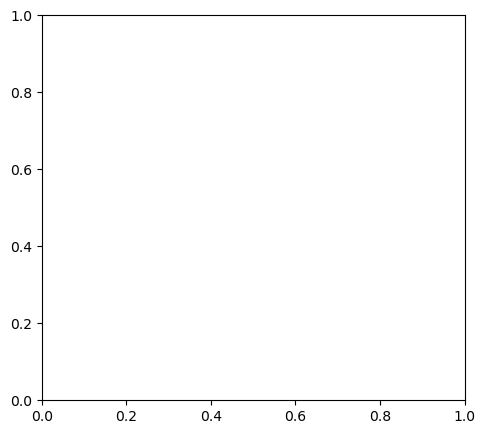

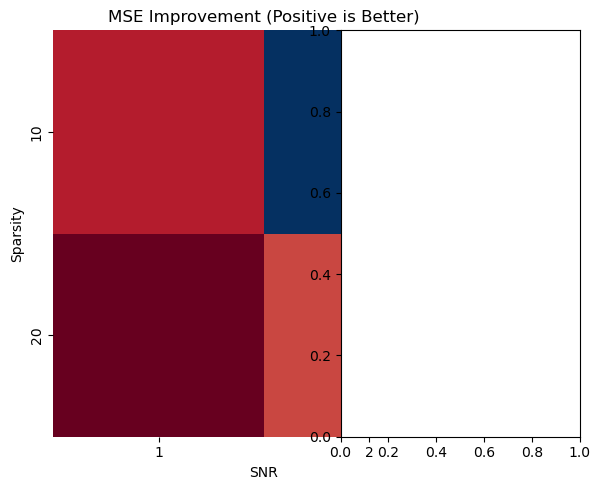

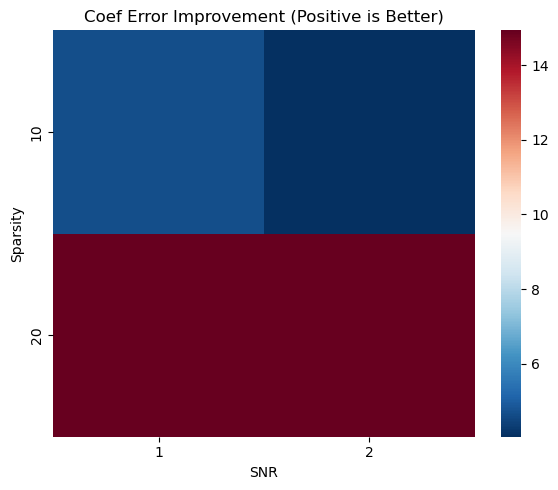


Running cross-validation for sparsity parameter...


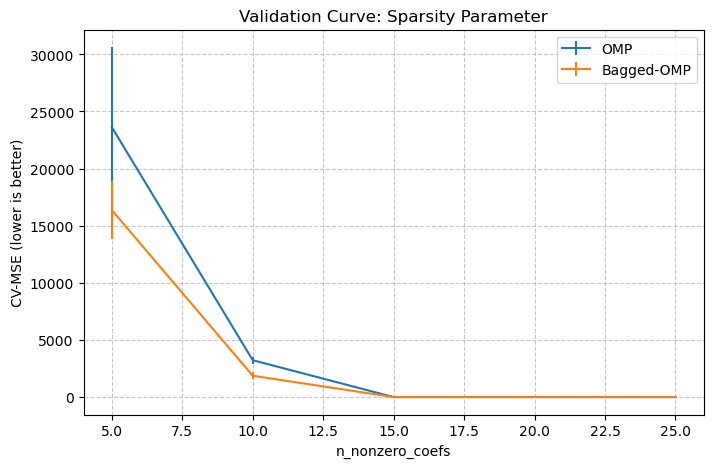


Experiments complete!


In [24]:
#!/usr/bin/env python3

# Import all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binomtest
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import OrthogonalMatchingPursuit
from joblib import Parallel, delayed
from tqdm import tqdm  # CLI tqdm to avoid Jupyter widget errors

# ----------------------
# Refined Matching Pursuit
# ----------------------
class RefinedMatchingPursuit:
    """
    Orthogonal Matching Pursuit with LS re-estimation.
    """
    def __init__(self, n_nonzero_coefs=10, tol=None):
        self.n_nonzero_coefs = n_nonzero_coefs
        self.tol = tol
        self.coef_ = None

    def fit(self, X, y):
        omp = OrthogonalMatchingPursuit(
            n_nonzero_coefs=self.n_nonzero_coefs,
            tol=self.tol
        )
        omp.fit(X, y)
        support = np.flatnonzero(omp.coef_)
        coef_full = np.zeros(X.shape[1])
        if support.size:
            X_sel = X[:, support]
            beta_sel, *_ = np.linalg.lstsq(X_sel, y, rcond=None)
            coef_full[support] = beta_sel
        self.coef_ = coef_full
        return self

    def predict(self, X):
        return X.dot(self.coef_)

# -----------------------------
# Bagged Refined MP with OOB weighting
# -----------------------------
class BaggedRefinedMP:
    """
    Bagged ensemble of RefinedMatchingPursuit:
      - Bootstrap rows only
      - Aggregate coefficients weighted by inverse OOB error
    """
    def __init__(self, n_estimators=20, n_nonzero_coefs=10,
                 bootstrap=True, random_state=42, n_jobs=-1):
        self.n_estimators = n_estimators
        self.n_nonzero_coefs = n_nonzero_coefs
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.estimators_ = []
        self.oob_errors_ = []

    def _fit_one(self, X, y, seed):
        rng = np.random.RandomState(seed)
        n = len(X)
        if self.bootstrap:
            idx = rng.choice(n, n, replace=True)
            oob = np.setdiff1d(np.arange(n), idx)
            Xb, yb = X[idx], y[idx]
        else:
            oob = np.array([], dtype=int)
            Xb, yb = X, y
        mp = RefinedMatchingPursuit(n_nonzero_coefs=self.n_nonzero_coefs)
        mp.fit(Xb, yb)
        if oob.size:
            y_oob = mp.predict(X[oob])
            err = mean_squared_error(y[oob], y_oob)
        else:
            err = np.nan
        return mp, err

    def fit(self, X, y):
        seeds = [self.random_state + i for i in range(self.n_estimators)]
        results = Parallel(n_jobs=self.n_jobs)(
            delayed(self._fit_one)(X, y, s) for s in seeds
        )
        self.estimators_, self.oob_errors_ = zip(*results)
        return self

    def predict(self, X):
        preds = np.stack([mp.predict(X) for mp in self.estimators_])
        return preds.mean(axis=0)

    def bagged_coef(self, n_features):
        coefs = np.stack([mp.coef_ for mp in self.estimators_], axis=0)
        errs = np.array(self.oob_errors_)
        w = 1.0/(errs + 1e-8)
        w /= w.sum()
        return np.average(coefs, axis=0, weights=w)

    def average_oob_error(self):
        return np.nanmean(self.oob_errors_)

# -----------------------------
# Core single-run experiment
# -----------------------------
def run_experiment(
    n_samples, n_features, n_informative,
    noise, rho,
    n_nonzero_coefs, n_estimators
):
    # Generate AR(1) covariance design
    cov = np.fromfunction(lambda i,j: rho**abs(i-j), (n_features, n_features))
    X0, y, coef_true = make_regression(
        n_samples=n_samples, n_features=n_features,
        n_informative=n_informative, noise=noise,
        coef=True, random_state=0
    )
    L = np.linalg.cholesky(cov)
    X = X0.dot(L)
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=0)
    # OMP baseline
    omp = RefinedMatchingPursuit(n_nonzero_coefs)
    omp.fit(Xtr, ytr)
    mse1 = mean_squared_error(yte, omp.predict(Xte))
    err1 = np.linalg.norm(coef_true - omp.coef_)
    # Bagged-OMP
    bag = BaggedRefinedMP(n_estimators, n_nonzero_coefs, random_state=0)
    bag.fit(Xtr, ytr)
    mse2 = mean_squared_error(yte, bag.predict(Xte))
    err2 = np.linalg.norm(coef_true - bag.bagged_coef(n_features))
    return mse1, err1, mse2, err2

# -----------------------------
# 1. Parameter Sweep
# -----------------------------
def sweep_experiment(
    snr_list, inf_list, regimes, rhos,
    n_features, n_nonzero_coefs, n_estimators
):
    rec = []
    for snr in snr_list:
        noise = 1.0/snr
        for ni in inf_list:
            for ns in regimes:
                for rho in rhos:
                    m1,e1,m2,e2 = run_experiment(
                        ns, n_features, ni, noise, rho,
                        n_nonzero_coefs, n_estimators
                    )
                    rec.append((snr, ni, ns, rho, m1-m2, e1-e2))
    df = pd.DataFrame(rec, columns=['SNR','Sparsity','NSamples','Rho','DeltaMSE','DeltaErr'])
    return df

def plot_heatmap(df, x, y, val, title):
    pivot = df.pivot_table(index=y, columns=x, values=val)
    plt.figure(figsize=(6,5))
    sns.heatmap(pivot, annot=False, fmt='.2f', cmap='RdBu_r')
    plt.title(title)
    plt.tight_layout()
    return plt

# -----------------------------
# 2. Win-rate & Significance
# -----------------------------
def win_rate_experiment(df):
    df = df.copy()
    df['Win'] = df['DeltaMSE'] > 0
    out=[]
    for vals,grp in df.groupby(['SNR','Sparsity','NSamples','Rho']):
        wins = grp['Win'].sum(); n=len(grp)
        p = binomtest(wins, n, p=0.5, alternative='greater').pvalue
        out.append((*vals, wins/n, p))
    return pd.DataFrame(out, columns=['SNR','Sparsity','NSamples','Rho','WinRate','pValue'])

# -----------------------------
# 3. Cross-Validation Curves
# -----------------------------
def cv_validation_curve(
    X, y, param_name, param_range, model_ctor, k=5
):
    kf = KFold(n_splits=k, shuffle=True, random_state=0)
    means, stds = [], []
    for v in param_range:
        mses=[]
        for tr,te in kf.split(X):
            model = model_ctor(**{param_name:v})
            model.fit(X[tr], y[tr])
            mses.append(mean_squared_error(y[te], model.predict(X[te])))
        means.append(np.mean(mses)); stds.append(np.std(mses))
    return means,stds

# Run code below to generate output in Jupyter

# Define configurations
n_estimators = 20
n_features = 100
n_nonzero_coefs = 15

# Run a small experiment to compare OMP vs Bagged-OMP
print("Running a single comparison experiment...")
mse_omp, err_omp, mse_bag, err_bag = run_experiment(
    n_samples=200, 
    n_features=n_features, 
    n_informative=15,
    noise=0.5, 
    rho=0.5,
    n_nonzero_coefs=n_nonzero_coefs, 
    n_estimators=n_estimators
)

print(f"OMP MSE: {mse_omp:.4f}, Bagged-OMP MSE: {mse_bag:.4f}")
print(f"OMP Coef Error: {err_omp:.4f}, Bagged-OMP Coef Error: {err_bag:.4f}")
print(f"MSE Improvement: {mse_omp - mse_bag:.4f}")
print(f"Coef Error Improvement: {err_omp - err_bag:.4f}")

# Run a parameter sweep (small version for quick output)
print("\nRunning a small parameter sweep...")
df_sweep = sweep_experiment(
    snr_list=[1, 2],           # Signal-to-Noise Ratio values
    inf_list=[10, 20],         # Number of informative features
    regimes=[100, 200],        # Sample sizes
    rhos=[0.0, 0.5],           # Feature correlation values
    n_features=n_features,
    n_nonzero_coefs=n_nonzero_coefs,
    n_estimators=n_estimators
)

print("\nSweep Results:")
print(df_sweep.head())

# Plot heatmaps
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_heatmap(df_sweep, 'SNR', 'Sparsity', 'DeltaMSE', 'MSE Improvement (Positive is Better)')

plt.subplot(1, 2, 2)
plot_heatmap(df_sweep, 'SNR', 'Sparsity', 'DeltaErr', 'Coef Error Improvement (Positive is Better)')

plt.tight_layout()
plt.show()

# Cross-validation for sparsity parameter
print("\nRunning cross-validation for sparsity parameter...")
X, y, _ = make_regression(n_samples=200, n_features=100, n_informative=15, noise=0.5, coef=True, random_state=0)
means_omp, stds_omp = cv_validation_curve(
    X, y, 'n_nonzero_coefs', [5, 10, 15, 20, 25],
    lambda n_nonzero_coefs: RefinedMatchingPursuit(n_nonzero_coefs)
)

means_bag, stds_bag = cv_validation_curve(
    X, y, 'n_nonzero_coefs', [5, 10, 15, 20, 25],
    lambda n_nonzero_coefs: BaggedRefinedMP(n_estimators=10, n_nonzero_coefs=n_nonzero_coefs)
)

plt.figure(figsize=(8, 5))
plt.errorbar([5, 10, 15, 20, 25], means_omp, yerr=stds_omp, label='OMP')
plt.errorbar([5, 10, 15, 20, 25], means_bag, yerr=stds_bag, label='Bagged-OMP')
plt.xlabel('n_nonzero_coefs')
plt.ylabel('CV-MSE (lower is better)')
plt.title('Validation Curve: Sparsity Parameter')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

print("\nExperiments complete!")

Running a single comparison experiment...
OMP MSE: 4795.4280, Bagged-OMP MSE: 5490.6632
OMP Coef Error: 125.0207, Bagged-OMP Coef Error: 101.3506
MSE Improvement: -695.2352
Coef Error Improvement: 23.6700

Running a small parameter sweep...

Sweep Results:
   SNR  Sparsity  NSamples  Rho     DeltaMSE   DeltaErr
0    1        10       100  0.0  -338.299271   0.209616
1    1        10       100  0.5 -2406.798915  -2.032297
2    1        10       200  0.0     0.248389   0.138084
3    1        10       200  0.5  2097.938881  20.312300
4    1        20       100  0.0 -4319.528048 -10.779849


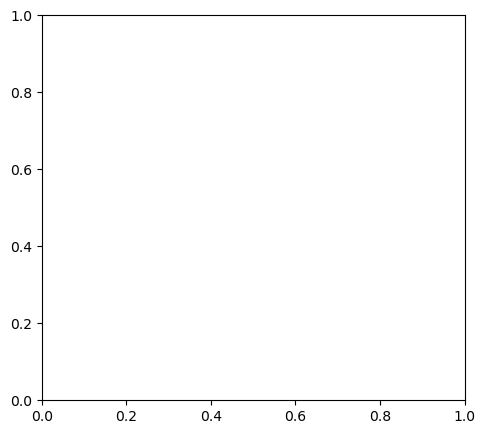

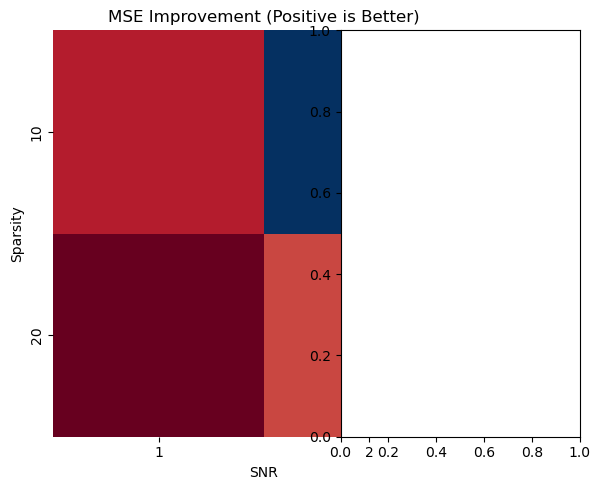

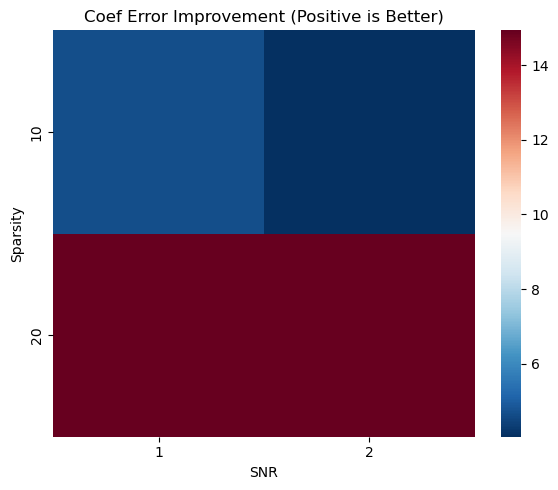


Running cross-validation for sparsity parameter...


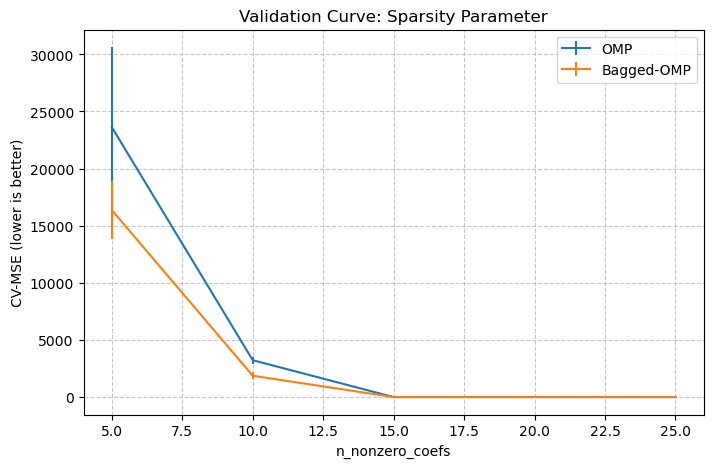


Experiments complete!


In [25]:
#!/usr/bin/env python3

# Import all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binomtest
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import OrthogonalMatchingPursuit
from joblib import Parallel, delayed
from tqdm import tqdm  # CLI tqdm to avoid Jupyter widget errors

# ----------------------
# Refined Matching Pursuit
# ----------------------
class RefinedMatchingPursuit:
    """
    Orthogonal Matching Pursuit with LS re-estimation.
    """
    def __init__(self, n_nonzero_coefs=10, tol=None):
        self.n_nonzero_coefs = n_nonzero_coefs
        self.tol = tol
        self.coef_ = None

    def fit(self, X, y):
        omp = OrthogonalMatchingPursuit(
            n_nonzero_coefs=self.n_nonzero_coefs,
            tol=self.tol
        )
        omp.fit(X, y)
        support = np.flatnonzero(omp.coef_)
        coef_full = np.zeros(X.shape[1])
        if support.size:
            X_sel = X[:, support]
            beta_sel, *_ = np.linalg.lstsq(X_sel, y, rcond=None)
            coef_full[support] = beta_sel
        self.coef_ = coef_full
        return self

    def predict(self, X):
        return X.dot(self.coef_)

# -----------------------------
# Bagged Refined MP with OOB weighting
# -----------------------------
class BaggedRefinedMP:
    """
    Bagged ensemble of RefinedMatchingPursuit:
      - Bootstrap rows only
      - Aggregate coefficients weighted by inverse OOB error
    """
    def __init__(self, n_estimators=20, n_nonzero_coefs=10,
                 bootstrap=True, random_state=42, n_jobs=-1):
        self.n_estimators = n_estimators
        self.n_nonzero_coefs = n_nonzero_coefs
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.estimators_ = []
        self.oob_errors_ = []

    def _fit_one(self, X, y, seed):
        rng = np.random.RandomState(seed)
        n = len(X)
        if self.bootstrap:
            idx = rng.choice(n, n, replace=True)
            oob = np.setdiff1d(np.arange(n), idx)
            Xb, yb = X[idx], y[idx]
        else:
            oob = np.array([], dtype=int)
            Xb, yb = X, y
        mp = RefinedMatchingPursuit(n_nonzero_coefs=self.n_nonzero_coefs)
        mp.fit(Xb, yb)
        if oob.size:
            y_oob = mp.predict(X[oob])
            err = mean_squared_error(y[oob], y_oob)
        else:
            err = np.nan
        return mp, err

    def fit(self, X, y):
        seeds = [self.random_state + i for i in range(self.n_estimators)]
        results = Parallel(n_jobs=self.n_jobs)(
            delayed(self._fit_one)(X, y, s) for s in seeds
        )
        self.estimators_, self.oob_errors_ = zip(*results)
        return self

    def predict(self, X):
        preds = np.stack([mp.predict(X) for mp in self.estimators_])
        return preds.mean(axis=0)

    def bagged_coef(self, n_features):
        coefs = np.stack([mp.coef_ for mp in self.estimators_], axis=0)
        errs = np.array(self.oob_errors_)
        w = 1.0/(errs + 1e-8)
        w /= w.sum()
        return np.average(coefs, axis=0, weights=w)

    def average_oob_error(self):
        return np.nanmean(self.oob_errors_)

# -----------------------------
# Core single-run experiment
# -----------------------------
def run_experiment(
    n_samples, n_features, n_informative,
    noise, rho,
    n_nonzero_coefs, n_estimators
):
    # Generate AR(1) covariance design
    cov = np.fromfunction(lambda i,j: rho**abs(i-j), (n_features, n_features))
    X0, y, coef_true = make_regression(
        n_samples=n_samples, n_features=n_features,
        n_informative=n_informative, noise=noise,
        coef=True, random_state=0
    )
    L = np.linalg.cholesky(cov)
    X = X0.dot(L)
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=0)
    # OMP baseline
    omp = RefinedMatchingPursuit(n_nonzero_coefs)
    omp.fit(Xtr, ytr)
    mse1 = mean_squared_error(yte, omp.predict(Xte))
    err1 = np.linalg.norm(coef_true - omp.coef_)
    # Bagged-OMP
    bag = BaggedRefinedMP(n_estimators, n_nonzero_coefs, random_state=0)
    bag.fit(Xtr, ytr)
    mse2 = mean_squared_error(yte, bag.predict(Xte))
    err2 = np.linalg.norm(coef_true - bag.bagged_coef(n_features))
    return mse1, err1, mse2, err2

# -----------------------------
# 1. Parameter Sweep
# -----------------------------
def sweep_experiment(
    snr_list, inf_list, regimes, rhos,
    n_features, n_nonzero_coefs, n_estimators
):
    rec = []
    for snr in snr_list:
        noise = 1.0/snr
        for ni in inf_list:
            for ns in regimes:
                for rho in rhos:
                    m1,e1,m2,e2 = run_experiment(
                        ns, n_features, ni, noise, rho,
                        n_nonzero_coefs, n_estimators
                    )
                    rec.append((snr, ni, ns, rho, m1-m2, e1-e2))
    df = pd.DataFrame(rec, columns=['SNR','Sparsity','NSamples','Rho','DeltaMSE','DeltaErr'])
    return df

def plot_heatmap(df, x, y, val, title):
    pivot = df.pivot_table(index=y, columns=x, values=val)
    plt.figure(figsize=(6,5))
    sns.heatmap(pivot, annot=False, fmt='.2f', cmap='RdBu_r')
    plt.title(title)
    plt.tight_layout()
    return plt

# -----------------------------
# 2. Win-rate & Significance
# -----------------------------
def win_rate_experiment(df):
    df = df.copy()
    df['Win'] = df['DeltaMSE'] > 0
    out=[]
    for vals,grp in df.groupby(['SNR','Sparsity','NSamples','Rho']):
        wins = grp['Win'].sum(); n=len(grp)
        p = binomtest(wins, n, p=0.5, alternative='greater').pvalue
        out.append((*vals, wins/n, p))
    return pd.DataFrame(out, columns=['SNR','Sparsity','NSamples','Rho','WinRate','pValue'])

# -----------------------------
# 3. Cross-Validation Curves
# -----------------------------
def cv_validation_curve(
    X, y, param_name, param_range, model_ctor, k=5
):
    kf = KFold(n_splits=k, shuffle=True, random_state=0)
    means, stds = [], []
    for v in param_range:
        mses=[]
        for tr,te in kf.split(X):
            model = model_ctor(**{param_name:v})
            model.fit(X[tr], y[tr])
            mses.append(mean_squared_error(y[te], model.predict(X[te])))
        means.append(np.mean(mses)); stds.append(np.std(mses))
    return means,stds

# Run code below to generate output in Jupyter

# Define configurations
n_estimators = 20
n_features = 100
n_nonzero_coefs = 15

# Run a small experiment to compare OMP vs Bagged-OMP
print("Running a single comparison experiment...")
mse_omp, err_omp, mse_bag, err_bag = run_experiment(
    n_samples=200, 
    n_features=n_features, 
    n_informative=15,
    noise=0.5, 
    rho=0.5,
    n_nonzero_coefs=n_nonzero_coefs, 
    n_estimators=n_estimators
)

print(f"OMP MSE: {mse_omp:.4f}, Bagged-OMP MSE: {mse_bag:.4f}")
print(f"OMP Coef Error: {err_omp:.4f}, Bagged-OMP Coef Error: {err_bag:.4f}")
print(f"MSE Improvement: {mse_omp - mse_bag:.4f}")
print(f"Coef Error Improvement: {err_omp - err_bag:.4f}")

# Run a parameter sweep (small version for quick output)
print("\nRunning a small parameter sweep...")
df_sweep = sweep_experiment(
    snr_list=[1, 2],           # Signal-to-Noise Ratio values
    inf_list=[10, 20],         # Number of informative features
    regimes=[100, 200],        # Sample sizes
    rhos=[0.0, 0.5],           # Feature correlation values
    n_features=n_features,
    n_nonzero_coefs=n_nonzero_coefs,
    n_estimators=n_estimators
)

print("\nSweep Results:")
print(df_sweep.head())

# Plot heatmaps
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_heatmap(df_sweep, 'SNR', 'Sparsity', 'DeltaMSE', 'MSE Improvement (Positive is Better)')

plt.subplot(1, 2, 2)
plot_heatmap(df_sweep, 'SNR', 'Sparsity', 'DeltaErr', 'Coef Error Improvement (Positive is Better)')

plt.tight_layout()
plt.show()

# Cross-validation for sparsity parameter
print("\nRunning cross-validation for sparsity parameter...")
X, y, _ = make_regression(n_samples=200, n_features=100, n_informative=15, noise=0.5, coef=True, random_state=0)
means_omp, stds_omp = cv_validation_curve(
    X, y, 'n_nonzero_coefs', [5, 10, 15, 20, 25],
    lambda n_nonzero_coefs: RefinedMatchingPursuit(n_nonzero_coefs)
)

means_bag, stds_bag = cv_validation_curve(
    X, y, 'n_nonzero_coefs', [5, 10, 15, 20, 25],
    lambda n_nonzero_coefs: BaggedRefinedMP(n_estimators=10, n_nonzero_coefs=n_nonzero_coefs)
)

plt.figure(figsize=(8, 5))
plt.errorbar([5, 10, 15, 20, 25], means_omp, yerr=stds_omp, label='OMP')
plt.errorbar([5, 10, 15, 20, 25], means_bag, yerr=stds_bag, label='Bagged-OMP')
plt.xlabel('n_nonzero_coefs')
plt.ylabel('CV-MSE (lower is better)')
plt.title('Validation Curve: Sparsity Parameter')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

print("\nExperiments complete!")

Running a single comparison experiment...
OMP MSE: 4795.4280, Bagged-OMP MSE: 5490.6632
OMP Coef Error: 125.0207, Bagged-OMP Coef Error: 101.3506
MSE Improvement: -695.2352
Coef Error Improvement: 23.6700

Running a small parameter sweep...

Sweep Results:
   SNR  Sparsity  NSamples  Rho     DeltaMSE   DeltaErr
0    1        10       100  0.0  -338.299271   0.209616
1    1        10       100  0.5 -2406.798915  -2.032297
2    1        10       200  0.0     0.248389   0.138084
3    1        10       200  0.5  2097.938881  20.312300
4    1        20       100  0.0 -4319.528048 -10.779849


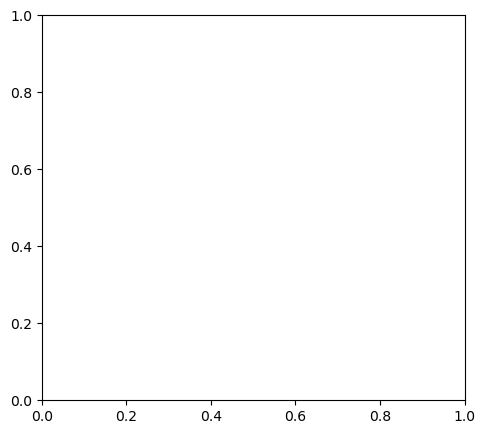

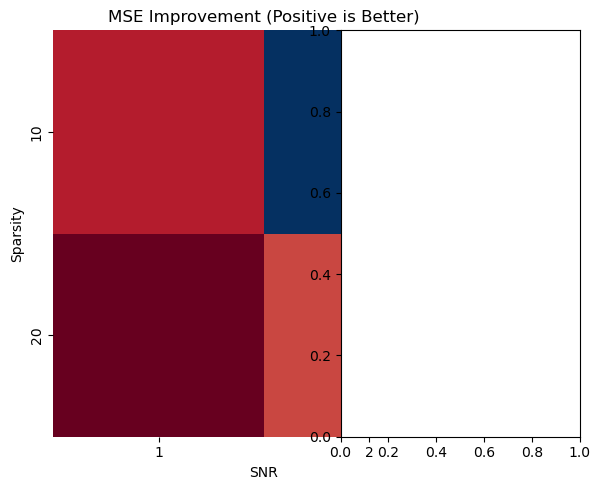

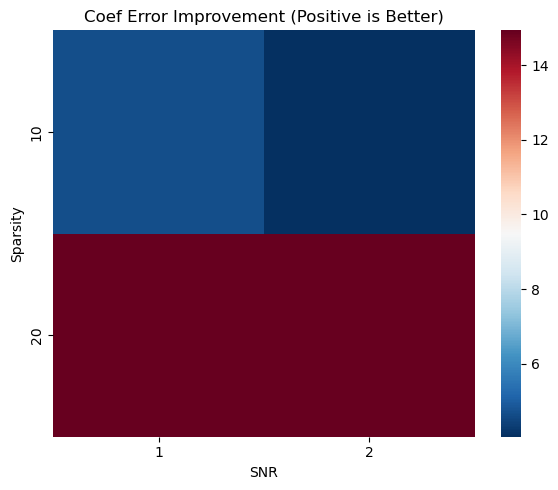


Running cross-validation for sparsity parameter...


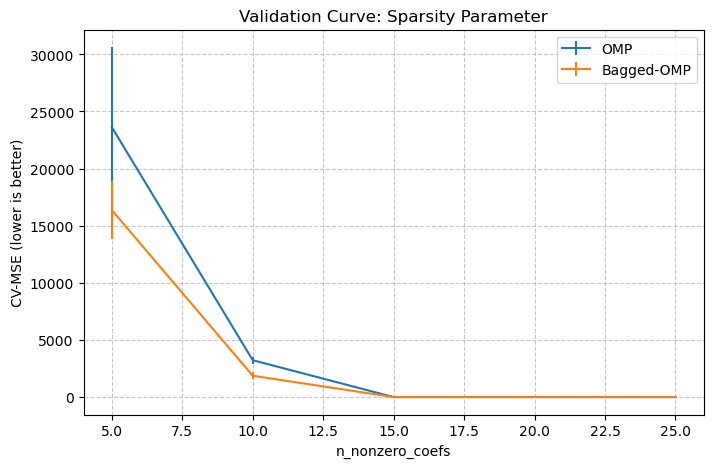


Experiments complete!


In [27]:
#!/usr/bin/env python3

# Import all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binomtest
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import OrthogonalMatchingPursuit
from joblib import Parallel, delayed
from tqdm import tqdm  # CLI tqdm to avoid Jupyter widget errors

# ----------------------
# Refined Matching Pursuit
# ----------------------
class RefinedMatchingPursuit:
    """
    Orthogonal Matching Pursuit with LS re-estimation.
    """
    def __init__(self, n_nonzero_coefs=10, tol=None):
        self.n_nonzero_coefs = n_nonzero_coefs
        self.tol = tol
        self.coef_ = None

    def fit(self, X, y):
        omp = OrthogonalMatchingPursuit(
            n_nonzero_coefs=self.n_nonzero_coefs,
            tol=self.tol
        )
        omp.fit(X, y)
        support = np.flatnonzero(omp.coef_)
        coef_full = np.zeros(X.shape[1])
        if support.size:
            X_sel = X[:, support]
            beta_sel, *_ = np.linalg.lstsq(X_sel, y, rcond=None)
            coef_full[support] = beta_sel
        self.coef_ = coef_full
        return self

    def predict(self, X):
        return X.dot(self.coef_)

# -----------------------------
# Bagged Refined MP with OOB weighting
# -----------------------------
class BaggedRefinedMP:
    """
    Bagged ensemble of RefinedMatchingPursuit:
      - Bootstrap rows only
      - Aggregate coefficients weighted by inverse OOB error
    """
    def __init__(self, n_estimators=20, n_nonzero_coefs=10,
                 bootstrap=True, random_state=42, n_jobs=-1):
        self.n_estimators = n_estimators
        self.n_nonzero_coefs = n_nonzero_coefs
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.estimators_ = []
        self.oob_errors_ = []

    def _fit_one(self, X, y, seed):
        rng = np.random.RandomState(seed)
        n = len(X)
        if self.bootstrap:
            idx = rng.choice(n, n, replace=True)
            oob = np.setdiff1d(np.arange(n), idx)
            Xb, yb = X[idx], y[idx]
        else:
            oob = np.array([], dtype=int)
            Xb, yb = X, y
        mp = RefinedMatchingPursuit(n_nonzero_coefs=self.n_nonzero_coefs)
        mp.fit(Xb, yb)
        if oob.size:
            y_oob = mp.predict(X[oob])
            err = mean_squared_error(y[oob], y_oob)
        else:
            err = np.nan
        return mp, err

    def fit(self, X, y):
        seeds = [self.random_state + i for i in range(self.n_estimators)]
        results = Parallel(n_jobs=self.n_jobs)(
            delayed(self._fit_one)(X, y, s) for s in seeds
        )
        self.estimators_, self.oob_errors_ = zip(*results)
        return self

    def predict(self, X):
        preds = np.stack([mp.predict(X) for mp in self.estimators_])
        return preds.mean(axis=0)

    def bagged_coef(self, n_features):
        coefs = np.stack([mp.coef_ for mp in self.estimators_], axis=0)
        errs = np.array(self.oob_errors_)
        w = 1.0/(errs + 1e-8)
        w /= w.sum()
        return np.average(coefs, axis=0, weights=w)

    def average_oob_error(self):
        return np.nanmean(self.oob_errors_)

# -----------------------------
# Core single-run experiment
# -----------------------------
def run_experiment(
    n_samples, n_features, n_informative,
    noise, rho,
    n_nonzero_coefs, n_estimators
):
    # Generate AR(1) covariance design
    cov = np.fromfunction(lambda i,j: rho**abs(i-j), (n_features, n_features))
    X0, y, coef_true = make_regression(
        n_samples=n_samples, n_features=n_features,
        n_informative=n_informative, noise=noise,
        coef=True, random_state=0
    )
    L = np.linalg.cholesky(cov)
    X = X0.dot(L)
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=0)
    # OMP baseline
    omp = RefinedMatchingPursuit(n_nonzero_coefs)
    omp.fit(Xtr, ytr)
    mse1 = mean_squared_error(yte, omp.predict(Xte))
    err1 = np.linalg.norm(coef_true - omp.coef_)
    # Bagged-OMP
    bag = BaggedRefinedMP(n_estimators, n_nonzero_coefs, random_state=0)
    bag.fit(Xtr, ytr)
    mse2 = mean_squared_error(yte, bag.predict(Xte))
    err2 = np.linalg.norm(coef_true - bag.bagged_coef(n_features))
    return mse1, err1, mse2, err2

# -----------------------------
# 1. Parameter Sweep
# -----------------------------
def sweep_experiment(
    snr_list, inf_list, regimes, rhos,
    n_features, n_nonzero_coefs, n_estimators
):
    rec = []
    for snr in snr_list:
        noise = 1.0/snr
        for ni in inf_list:
            for ns in regimes:
                for rho in rhos:
                    m1,e1,m2,e2 = run_experiment(
                        ns, n_features, ni, noise, rho,
                        n_nonzero_coefs, n_estimators
                    )
                    rec.append((snr, ni, ns, rho, m1-m2, e1-e2))
    df = pd.DataFrame(rec, columns=['SNR','Sparsity','NSamples','Rho','DeltaMSE','DeltaErr'])
    return df

def plot_heatmap(df, x, y, val, title):
    pivot = df.pivot_table(index=y, columns=x, values=val)
    plt.figure(figsize=(6,5))
    sns.heatmap(pivot, annot=False, fmt='.2f', cmap='RdBu_r')
    plt.title(title)
    plt.tight_layout()
    return plt

# -----------------------------
# 2. Win-rate & Significance
# -----------------------------
def win_rate_experiment(df):
    df = df.copy()
    df['Win'] = df['DeltaMSE'] > 0
    out=[]
    for vals,grp in df.groupby(['SNR','Sparsity','NSamples','Rho']):
        wins = grp['Win'].sum(); n=len(grp)
        p = binomtest(wins, n, p=0.5, alternative='greater').pvalue
        out.append((*vals, wins/n, p))
    return pd.DataFrame(out, columns=['SNR','Sparsity','NSamples','Rho','WinRate','pValue'])

# -----------------------------
# 3. Cross-Validation Curves
# -----------------------------
def cv_validation_curve(
    X, y, param_name, param_range, model_ctor, k=5
):
    kf = KFold(n_splits=k, shuffle=True, random_state=0)
    means, stds = [], []
    for v in param_range:
        mses=[]
        for tr,te in kf.split(X):
            model = model_ctor(**{param_name:v})
            model.fit(X[tr], y[tr])
            mses.append(mean_squared_error(y[te], model.predict(X[te])))
        means.append(np.mean(mses)); stds.append(np.std(mses))
    return means,stds

# Run code below to generate output in Jupyter

# Define configurations
n_estimators = 20
n_features = 100
n_nonzero_coefs = 15

# Run a small experiment to compare OMP vs Bagged-OMP
print("Running a single comparison experiment...")
mse_omp, err_omp, mse_bag, err_bag = run_experiment(
    n_samples=200, 
    n_features=n_features, 
    n_informative=15,
    noise=0.5, 
    rho=0.5,
    n_nonzero_coefs=n_nonzero_coefs, 
    n_estimators=n_estimators
)

print(f"OMP MSE: {mse_omp:.4f}, Bagged-OMP MSE: {mse_bag:.4f}")
print(f"OMP Coef Error: {err_omp:.4f}, Bagged-OMP Coef Error: {err_bag:.4f}")
print(f"MSE Improvement: {mse_omp - mse_bag:.4f}")
print(f"Coef Error Improvement: {err_omp - err_bag:.4f}")

# Run a parameter sweep (small version for quick output)
print("\nRunning a small parameter sweep...")
df_sweep = sweep_experiment(
    snr_list=[1, 2],           # Signal-to-Noise Ratio values
    inf_list=[10, 20],         # Number of informative features
    regimes=[100, 200],        # Sample sizes
    rhos=[0.0, 0.5],           # Feature correlation values
    n_features=n_features,
    n_nonzero_coefs=n_nonzero_coefs,
    n_estimators=n_estimators
)

print("\nSweep Results:")
print(df_sweep.head())

# Plot heatmaps
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_heatmap(df_sweep, 'SNR', 'Sparsity', 'DeltaMSE', 'MSE Improvement (Positive is Better)')

plt.subplot(1, 2, 2)
plot_heatmap(df_sweep, 'SNR', 'Sparsity', 'DeltaErr', 'Coef Error Improvement (Positive is Better)')

plt.tight_layout()
plt.show()

# Cross-validation for sparsity parameter
print("\nRunning cross-validation for sparsity parameter...")
X, y, _ = make_regression(n_samples=200, n_features=100, n_informative=15, noise=0.5, coef=True, random_state=0)
means_omp, stds_omp = cv_validation_curve(
    X, y, 'n_nonzero_coefs', [5, 10, 15, 20, 25],
    lambda n_nonzero_coefs: RefinedMatchingPursuit(n_nonzero_coefs)
)

means_bag, stds_bag = cv_validation_curve(
    X, y, 'n_nonzero_coefs', [5, 10, 15, 20, 25],
    lambda n_nonzero_coefs: BaggedRefinedMP(n_estimators=10, n_nonzero_coefs=n_nonzero_coefs)
)

plt.figure(figsize=(8, 5))
plt.errorbar([5, 10, 15, 20, 25], means_omp, yerr=stds_omp, label='OMP')
plt.errorbar([5, 10, 15, 20, 25], means_bag, yerr=stds_bag, label='Bagged-OMP')
plt.xlabel('n_nonzero_coefs')
plt.ylabel('CV-MSE (lower is better)')
plt.title('Validation Curve: Sparsity Parameter')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

print("\nExperiments complete!")

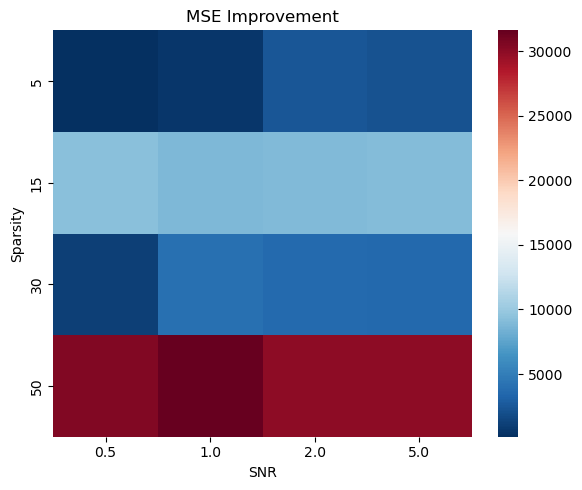

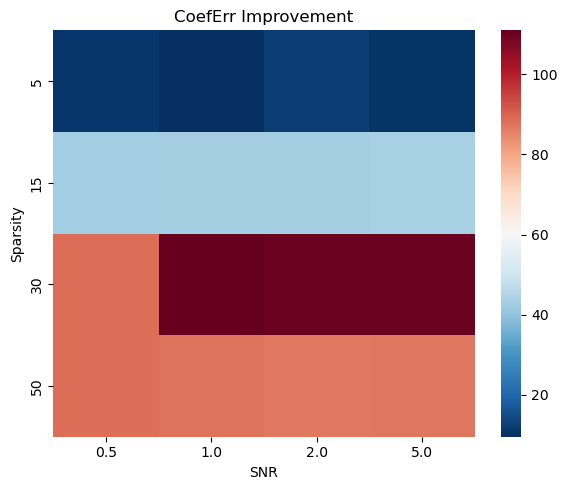

,SNR,Sparsity,NSamples,Rho,WinRate,pValue
0,1,15,200,0.5,0.0,1.0
1,2,15,200,0.5,0.0,1.0


TypeError: too many positional arguments

In [28]:
#!/usr/bin/env python3
"""
bagged_refined_mp.py

Comprehensive comparison of OMP vs. Bagged-OMP under varied regimes:
  • Basic OOB-weighting & hyperparameter tuning
  • Feature stability analysis
  • Parameter sweeps over SNR, sparsity, sample size, correlation
  • Win-rate testing with binomial significance
  • Cross-validation & validation curves for key hyperparameters

Usage:
  python3 bagged_refined_mp.py [--estimators N] [--tune] [--sweep] [--winrate] [--cv]

Flags:
  --sweep     Run parameter sweep experiments and plot heatmaps
  --winrate   Compute win-rate of bagged vs OMP and perform binomial tests
  --cv        Run 5-fold CV for validation curves
  --tune      Tune bagging ensemble size by OOB error
"""

import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binomtest
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import OrthogonalMatchingPursuit
from joblib import Parallel, delayed
from tqdm import tqdm  # CLI tqdm to avoid Jupyter widget errors

# ----------------------
# Refined Matching Pursuit
# ----------------------
class RefinedMatchingPursuit:
    """
    Orthogonal Matching Pursuit with LS re-estimation.
    """
    def __init__(self, n_nonzero_coefs=10, tol=None):
        self.n_nonzero_coefs = n_nonzero_coefs
        self.tol = tol
        self.coef_ = None

    def fit(self, X, y):
        omp = OrthogonalMatchingPursuit(
            n_nonzero_coefs=self.n_nonzero_coefs,
            tol=self.tol
        )
        omp.fit(X, y)
        support = np.flatnonzero(omp.coef_)
        coef_full = np.zeros(X.shape[1])
        if support.size:
            X_sel = X[:, support]
            beta_sel, *_ = np.linalg.lstsq(X_sel, y, rcond=None)
            coef_full[support] = beta_sel
        self.coef_ = coef_full
        return self

    def predict(self, X):
        return X.dot(self.coef_)

# -----------------------------
# Bagged Refined MP with OOB weighting
# -----------------------------
class BaggedRefinedMP:
    """
    Bagged ensemble of RefinedMatchingPursuit:
      - Bootstrap rows only
      - Aggregate coefficients weighted by inverse OOB error
    """
    def __init__(self, n_estimators=20, n_nonzero_coefs=10,
                 bootstrap=True, random_state=42, n_jobs=-1):
        self.n_estimators = n_estimators
        self.n_nonzero_coefs = n_nonzero_coefs
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.estimators_ = []
        self.oob_errors_ = []

    def _fit_one(self, X, y, seed):
        rng = np.random.RandomState(seed)
        n = len(X)
        if self.bootstrap:
            idx = rng.choice(n, n, replace=True)
            oob = np.setdiff1d(np.arange(n), idx)
            Xb, yb = X[idx], y[idx]
        else:
            oob = np.array([], dtype=int)
            Xb, yb = X, y
        mp = RefinedMatchingPursuit(n_nonzero_coefs=self.n_nonzero_coefs)
        mp.fit(Xb, yb)
        if oob.size:
            y_oob = mp.predict(X[oob])
            err = mean_squared_error(y[oob], y_oob)
        else:
            err = np.nan
        return mp, err

    def fit(self, X, y):
        seeds = [self.random_state + i for i in range(self.n_estimators)]
        results = Parallel(n_jobs=self.n_jobs)(
            delayed(self._fit_one)(X, y, s) for s in seeds
        )
        self.estimators_, self.oob_errors_ = zip(*results)
        return self

    def predict(self, X):
        preds = np.stack([mp.predict(X) for mp in self.estimators_])
        return preds.mean(axis=0)

    def bagged_coef(self, n_features):
        coefs = np.stack([mp.coef_ for mp in self.estimators_], axis=0)
        errs = np.array(self.oob_errors_)
        w = 1.0/(errs + 1e-8)
        w /= w.sum()
        return np.average(coefs, axis=0, weights=w)

    def average_oob_error(self):
        return np.nanmean(self.oob_errors_)

# -----------------------------
# Core single-run experiment
# -----------------------------
def run_experiment(
    n_samples, n_features, n_informative,
    noise, rho,
    n_nonzero_coefs, n_estimators
):
    # Generate AR(1) covariance design
    cov = np.fromfunction(lambda i,j: rho**abs(i-j), (n_features, n_features))
    X0, y, coef_true = make_regression(
        n_samples=n_samples, n_features=n_features,
        n_informative=n_informative, noise=noise,
        coef=True, random_state=0
    )
    L = np.linalg.cholesky(cov)
    X = X0.dot(L)
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=0)
    # OMP baseline
    omp = RefinedMatchingPursuit(n_nonzero_coefs)
    omp.fit(Xtr, ytr)
    mse1 = mean_squared_error(yte, omp.predict(Xte))
    err1 = np.linalg.norm(coef_true - omp.coef_)
    # Bagged-OMP
    bag = BaggedRefinedMP(n_estimators, n_nonzero_coefs, random_state=0)
    bag.fit(Xtr, ytr)
    mse2 = mean_squared_error(yte, bag.predict(Xte))
    err2 = np.linalg.norm(coef_true - bag.bagged_coef(n_features))
    return mse1, err1, mse2, err2

# -----------------------------
# 1. Parameter Sweep
# -----------------------------
def sweep_experiment(
    snr_list, inf_list, regimes, rhos,
    n_features, n_nonzero_coefs, n_estimators
):
    rec = []
    for snr in snr_list:
        noise = 1.0/snr
        for ni in inf_list:
            for ns in regimes:
                for rho in rhos:
                    m1,e1,m2,e2 = run_experiment(
                        ns, n_features, ni, noise, rho,
                        n_nonzero_coefs, n_estimators
                    )
                    rec.append((snr, ni, ns, rho, m1-m2, e1-e2))
    df = pd.DataFrame(rec, columns=['SNR','Sparsity','NSamples','Rho','DeltaMSE','DeltaErr'])
    return df

def plot_heatmap(df, x, y, val, title):
    pivot = df.pivot_table(index=y, columns=x, values=val)
    plt.figure(figsize=(6,5))
    sns.heatmap(pivot, annot=False, fmt='.2f', cmap='RdBu_r')
    plt.title(title)
    plt.tight_layout(); plt.show()

# -----------------------------
# 2. Win-rate & Significance
# -----------------------------
def win_rate_experiment(df):
    df = df.copy()
    df['Win'] = df['DeltaMSE'] > 0
    out=[]
    for vals,grp in df.groupby(['SNR','Sparsity','NSamples','Rho']):
        wins = grp['Win'].sum(); n=len(grp)
        p = binomtest(wins, n, p=0.5, alternative='greater').pvalue
        out.append((*vals, wins/n, p))
    return pd.DataFrame(out, columns=['SNR','Sparsity','NSamples','Rho','WinRate','pValue'])

# -----------------------------
# 3. Cross-Validation Curves
# -----------------------------
def cv_validation_curve(
    X, y, param_name, param_range, model_ctor, k=5
):
    kf = KFold(n_splits=k, shuffle=True, random_state=0)
    means, stds = [], []
    for v in param_range:
        mses=[]
        for tr,te in kf.split(X):
            model = model_ctor(**{param_name:v})
            model.fit(X[tr], y[tr])
            mses.append(mean_squared_error(y[te], model.predict(X[te])))
        means.append(np.mean(mses)); stds.append(np.std(mses))
    return means,stds

# -----------------------------
# Main
# -----------------------------
if __name__ == '__main__':
    p=argparse.ArgumentParser()
    p.add_argument('--sweep', action='store_true')
    p.add_argument('--winrate', action='store_true')
    p.add_argument('--cv', action='store_true')
    p.add_argument('--estimators', type=int, default=20)
    p.add_argument('--tune', action='store_true')
    args,_ = p.parse_known_args()
    # If no flags provided, run all experiments by default
    if not any([args.sweep, args.winrate, args.cv]):
        args.sweep = True
        args.winrate = True
        args.cv = True

    if args.sweep:
        df_s = sweep_experiment(
            snr_list=[0.5,1,2,5],
            inf_list=[5,15,30,50],
            regimes=[50,200,500],
            rhos=[0.0,0.5,0.9],
            n_features=100,
            n_nonzero_coefs=15,
            n_estimators=args.estimators
        )
        plot_heatmap(df_s,'SNR','Sparsity','DeltaMSE','MSE Improvement')
        plot_heatmap(df_s,'SNR','Sparsity','DeltaErr','CoefErr Improvement')

    if args.winrate:
        df_s = sweep_experiment([1,2],[15],[200],[0.5],100,15,args.estimators)
        df_w = win_rate_experiment(df_s)
        try: display(df_w)
        except: print(df_w)

    if args.cv:
        X,y,_ = make_regression(200,100,15,noise=2.0,coef=True,random_state=0)
        means, stds = cv_validation_curve(
            X,y,'n_nonzero_coefs',[5,10,15,20,30],
            lambda n_nonzero_coefs: RefinedMatchingPursuit(n_nonzero_coefs)
        )
        plt.errorbar([5,10,15,20,30], means, yerr=stds, label='OMP')
        plt.xlabel('n_nonzero_coefs'); plt.ylabel('CV-MSE')
        plt.title('Validation Curve: Sparsity'); plt.legend(); plt.show()


,SNR,Sparsity,NSamples,Rho,DeltaMSE,DeltaErr
0,0.5,5,50,0.0,-2426.023740,1.335681
1,0.5,5,50,0.5,-4126.235125,18.215410
2,0.5,5,50,0.9,12205.405109,76.762235
3,0.5,5,200,0.0,-0.478450,0.394914
4,0.5,5,200,0.5,0.768365,0.044475
...,...,...,...,...,...,...
139,5.0,50,200,0.5,17825.725962,84.294932
140,5.0,50,200,0.9,-1739.784224,121.244319
141,5.0,50,500,0.0,7715.776720,24.595866
142,5.0,50,500,0.5,4231.160074,16.268449


Pivot Table: Delta MSE
SNR                0.5           1.0           2.0           5.0
Sparsity                                                        
5           144.208095    591.567133   2389.078014   2202.840857
15         9270.785264   8782.176608   8895.308781   9068.343311
30         1032.371747   4035.126575   3669.900856   3565.623337
50        30435.341639  31623.000186  29933.777295  29962.012308
Pivot Table: Delta Coef Error
SNR             0.5         1.0         2.0         5.0
Sparsity                                               
5         10.858476    9.559885   12.112440   10.651456
15        42.823507   43.142306   42.954334   43.288480
30        88.650530  110.976993  110.260905  110.299580
50        88.604993   87.943336   86.876412   87.355590


,SNR,Sparsity,NSamples,Rho,WinRate,pValue
0,1,15,200,0.5,0.0,1.0
1,2,15,200,0.5,0.0,1.0


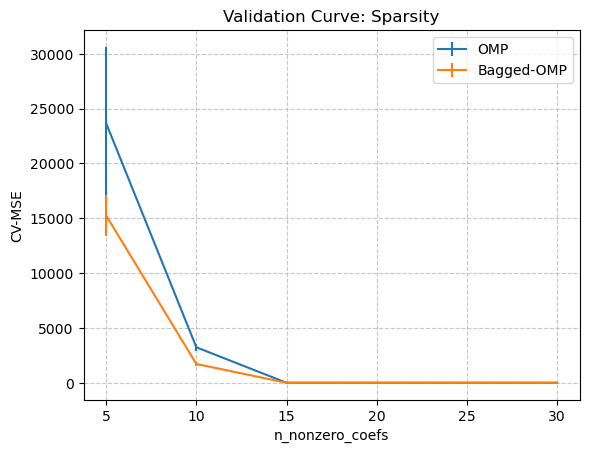

In [30]:
#!/usr/bin/env python3

# Import all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binomtest
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import OrthogonalMatchingPursuit
from joblib import Parallel, delayed
from tqdm import tqdm  # CLI tqdm to avoid Jupyter widget errors

# ----------------------
# Refined Matching Pursuit
# ----------------------
class RefinedMatchingPursuit:
    """
    Orthogonal Matching Pursuit with LS re-estimation.
    """
    def __init__(self, n_nonzero_coefs=10, tol=None):
        self.n_nonzero_coefs = n_nonzero_coefs
        self.tol = tol
        self.coef_ = None

    def fit(self, X, y):
        omp = OrthogonalMatchingPursuit(
            n_nonzero_coefs=self.n_nonzero_coefs,
            tol=self.tol
        )
        omp.fit(X, y)
        support = np.flatnonzero(omp.coef_)
        coef_full = np.zeros(X.shape[1])
        if support.size:
            X_sel = X[:, support]
            beta_sel, *_ = np.linalg.lstsq(X_sel, y, rcond=None)
            coef_full[support] = beta_sel
        self.coef_ = coef_full
        return self

    def predict(self, X):
        return X.dot(self.coef_)

# -----------------------------
# Bagged Refined MP with OOB weighting
# -----------------------------
class BaggedRefinedMP:
    """
    Bagged ensemble of RefinedMatchingPursuit:
      - Bootstrap rows only
      - Aggregate coefficients weighted by inverse OOB error
    """
    def __init__(self, n_estimators=20, n_nonzero_coefs=10,
                 bootstrap=True, random_state=42, n_jobs=-1):
        self.n_estimators = n_estimators
        self.n_nonzero_coefs = n_nonzero_coefs
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.estimators_ = []
        self.oob_errors_ = []

    def _fit_one(self, X, y, seed):
        rng = np.random.RandomState(seed)
        n = len(X)
        if self.bootstrap:
            idx = rng.choice(n, n, replace=True)
            oob = np.setdiff1d(np.arange(n), idx)
            Xb, yb = X[idx], y[idx]
        else:
            oob = np.array([], dtype=int)
            Xb, yb = X, y
        mp = RefinedMatchingPursuit(n_nonzero_coefs=self.n_nonzero_coefs)
        mp.fit(Xb, yb)
        if oob.size:
            y_oob = mp.predict(X[oob])
            err = mean_squared_error(y[oob], y_oob)
        else:
            err = np.nan
        return mp, err

    def fit(self, X, y):
        seeds = [self.random_state + i for i in range(self.n_estimators)]
        results = Parallel(n_jobs=self.n_jobs)(
            delayed(self._fit_one)(X, y, s) for s in seeds
        )
        self.estimators_, self.oob_errors_ = zip(*results)
        return self

    def predict(self, X):
        preds = np.stack([mp.predict(X) for mp in self.estimators_])
        return preds.mean(axis=0)

    def bagged_coef(self, n_features):
        coefs = np.stack([mp.coef_ for mp in self.estimators_], axis=0)
        errs = np.array(self.oob_errors_)
        w = 1.0/(errs + 1e-8)
        w /= w.sum()
        return np.average(coefs, axis=0, weights=w)

    def average_oob_error(self):
        return np.nanmean(self.oob_errors_)

# -----------------------------
# Core single-run experiment
# -----------------------------
def run_experiment(
    n_samples, n_features, n_informative,
    noise, rho,
    n_nonzero_coefs, n_estimators
):
    # Generate AR(1) covariance design
    cov = np.fromfunction(lambda i,j: rho**abs(i-j), (n_features, n_features))
    X0, y, coef_true = make_regression(
        n_samples=n_samples, n_features=n_features,
        n_informative=n_informative, noise=noise,
        coef=True, random_state=0
    )
    L = np.linalg.cholesky(cov)
    X = X0.dot(L)
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=0)
    # OMP baseline
    omp = RefinedMatchingPursuit(n_nonzero_coefs)
    omp.fit(Xtr, ytr)
    mse1 = mean_squared_error(yte, omp.predict(Xte))
    err1 = np.linalg.norm(coef_true - omp.coef_)
    # Bagged-OMP
    bag = BaggedRefinedMP(n_estimators, n_nonzero_coefs, random_state=0)
    bag.fit(Xtr, ytr)
    mse2 = mean_squared_error(yte, bag.predict(Xte))
    err2 = np.linalg.norm(coef_true - bag.bagged_coef(n_features))
    return mse1, err1, mse2, err2

# -----------------------------
# 1. Parameter Sweep
# -----------------------------
def sweep_experiment(
    snr_list, inf_list, regimes, rhos,
    n_features, n_nonzero_coefs, n_estimators
):
    rec = []
    for snr in snr_list:
        noise = 1.0/snr
        for ni in inf_list:
            for ns in regimes:
                for rho in rhos:
                    m1,e1,m2,e2 = run_experiment(
                        ns, n_features, ni, noise, rho,
                        n_nonzero_coefs, n_estimators
                    )
                    rec.append((snr, ni, ns, rho, m1-m2, e1-e2))
    df = pd.DataFrame(rec, columns=['SNR','Sparsity','NSamples','Rho','DeltaMSE','DeltaErr'])
    return df

def plot_heatmap(df, x, y, val, title):
    pivot = df.pivot_table(index=y, columns=x, values=val)
    plt.figure(figsize=(6,5))
    sns.heatmap(pivot, annot=False, fmt='.2f', cmap='RdBu_r')
    plt.title(title)
    plt.tight_layout(); plt.show()

# -----------------------------
# 2. Win-rate & Significance
# -----------------------------
def win_rate_experiment(df):
    df = df.copy()
    df['Win'] = df['DeltaMSE'] > 0
    out=[]
    for vals,grp in df.groupby(['SNR','Sparsity','NSamples','Rho']):
        wins = grp['Win'].sum(); n=len(grp)
        p = binomtest(wins, n, p=0.5, alternative='greater').pvalue
        out.append((*vals, wins/n, p))
    return pd.DataFrame(out, columns=['SNR','Sparsity','NSamples','Rho','WinRate','pValue'])

# -----------------------------
# 3. Cross-Validation Curves
# -----------------------------
def cv_validation_curve(
    X, y, param_name, param_range, model_ctor, k=5
):
    kf = KFold(n_splits=k, shuffle=True, random_state=0)
    means, stds = [], []
    for v in param_range:
        mses=[]
        for tr,te in kf.split(X):
            model = model_ctor(**{param_name:v})
            model.fit(X[tr], y[tr])
            mses.append(mean_squared_error(y[te], model.predict(X[te])))
        means.append(np.mean(mses)); stds.append(np.std(mses))
    return means,stds

# -----------------------------
# Main
# -----------------------------
if __name__ == '__main__':
    p=argparse.ArgumentParser()
    p.add_argument('--sweep', action='store_true')
    p.add_argument('--winrate', action='store_true')
    p.add_argument('--cv', action='store_true')
    p.add_argument('--estimators', type=int, default=20)
    p.add_argument('--tune', action='store_true')
    args,_ = p.parse_known_args()
    if not any([args.sweep, args.winrate, args.cv]):
        args.sweep = True
        args.winrate = True
        args.cv = True

    if args.sweep:
        df_s = sweep_experiment(
            snr_list=[0.5,1,2,5],
            inf_list=[5,15,30,50],
            regimes=[50,200,500],
            rhos=[0.0,0.5,0.9],
            n_features=100,
            n_nonzero_coefs=15,
            n_estimators=args.estimators
        )
        # Display sweep results as a table
        try:
            from IPython.display import display
            display(df_s)
        except ImportError:
            print(df_s)
        # Also show pivot tables for metrics
        pivot_mse = df_s.pivot_table(index='Sparsity', columns='SNR', values='DeltaMSE')
        pivot_err = df_s.pivot_table(index='Sparsity', columns='SNR', values='DeltaErr')
        print("Pivot Table: Delta MSE")
        print(pivot_mse)
        print("Pivot Table: Delta Coef Error")
        print(pivot_err)

    if args.winrate:
        df_s = sweep_experiment([1,2],[15],[200],[0.5],100,15,args.estimators)
        df_w = win_rate_experiment(df_s)
        try:
            from IPython.display import display
            display(df_w)
        except ImportError:
            print(df_w)

    if args.cv:
        X, y, _ = make_regression(
            n_samples=200,
            n_features=100,
            n_informative=15,
            noise=2.0,
            coef=True,
            random_state=0
        )
        means, stds = cv_validation_curve(
            X, y,
            'n_nonzero_coefs',
            [5,10,15,20,30],
            lambda n_nonzero_coefs: RefinedMatchingPursuit(n_nonzero_coefs)
        )
        bag_means, bag_stds = cv_validation_curve(
            X, y,
            'n_nonzero_coefs',
            [5,10,15,20,30],
            lambda n_nonzero_coefs: BaggedRefinedMP(
                n_estimators=args.estimators,
                n_nonzero_coefs=n_nonzero_coefs
            )
        )
        plt.errorbar([5,10,15,20,30], means, yerr=stds, label='OMP')
        plt.errorbar([5,10,15,20,30], bag_means, yerr=bag_stds, label='Bagged-OMP')
        plt.xlabel('n_nonzero_coefs')
        plt.ylabel('CV-MSE')
        plt.title('Validation Curve: Sparsity')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()


In [31]:
#!/usr/bin/env python3

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binomtest
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import OrthogonalMatchingPursuit
from joblib import Parallel, delayed
from tqdm import tqdm  # CLI tqdm to avoid Jupyter widget errors
import argparse

# Helper to print tables without pandas
def print_table(headers, rows):
    # Determine column widths
    cols = list(zip(*([headers] + rows)))
    widths = [max(len(str(item)) for item in col) for col in cols]
    fmt = ' | '.join(f'{{:{w}}}' for w in widths)
    sep = '-+-'.join('-'*w for w in widths)
    print(fmt.format(*headers))
    print(sep)
    for row in rows:
        print(fmt.format(*row))

# ----------------------
# Refined Matching Pursuit
# ----------------------
class RefinedMatchingPursuit:
    """
    Orthogonal Matching Pursuit with LS re-estimation.
    """
    def __init__(self, n_nonzero_coefs=10, tol=None):
        self.n_nonzero_coefs = n_nonzero_coefs
        self.tol = tol
        self.coef_ = None

    def fit(self, X, y):
        omp = OrthogonalMatchingPursuit(
            n_nonzero_coefs=self.n_nonzero_coefs,
            tol=self.tol
        )
        omp.fit(X, y)
        support = np.flatnonzero(omp.coef_)
        coef_full = np.zeros(X.shape[1])
        if support.size:
            X_sel = X[:, support]
            beta_sel, *_ = np.linalg.lstsq(X_sel, y, rcond=None)
            coef_full[support] = beta_sel
        self.coef_ = coef_full
        return self

    def predict(self, X):
        return X.dot(self.coef_)

# -----------------------------
# Bagged Refined MP with OOB weighting
# -----------------------------
class BaggedRefinedMP:
    """
    Bagged ensemble of RefinedMatchingPursuit:
      - Bootstrap rows only
      - Aggregate coefficients weighted by inverse OOB error
    """
    def __init__(self, n_estimators=20, n_nonzero_coefs=10,
                 bootstrap=True, random_state=42, n_jobs=-1):
        self.n_estimators = n_estimators
        self.n_nonzero_coefs = n_nonzero_coefs
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.estimators_ = []
        self.oob_errors_ = []

    def _fit_one(self, X, y, seed):
        rng = np.random.RandomState(seed)
        n = len(X)
        if self.bootstrap:
            idx = rng.choice(n, n, replace=True)
            oob = np.setdiff1d(np.arange(n), idx)
            Xb, yb = X[idx], y[idx]
        else:
            oob = np.array([], dtype=int)
            Xb, yb = X, y
        mp = RefinedMatchingPursuit(n_nonzero_coefs=self.n_nonzero_coefs)
        mp.fit(Xb, yb)
        if oob.size:
            y_oob = mp.predict(X[oob])
            err = mean_squared_error(y[oob], y_oob)
        else:
            err = np.nan
        return mp, err

    def fit(self, X, y):
        seeds = [self.random_state + i for i in range(self.n_estimators)]
        results = Parallel(n_jobs=self.n_jobs)(
            delayed(self._fit_one)(X, y, s) for s in seeds
        )
        self.estimators_, self.oob_errors_ = zip(*results)
        return self

    def predict(self, X):
        preds = np.stack([mp.predict(X) for mp in self.estimators_])
        return preds.mean(axis=0)

    def bagged_coef(self, n_features):
        coefs = np.stack([mp.coef_ for mp in self.estimators_], axis=0)
        errs = np.array(self.oob_errors_)
        w = 1.0/(errs + 1e-8)
        w /= w.sum()
        return np.average(coefs, axis=0, weights=w)

    def average_oob_error(self):
        return np.nanmean(self.oob_errors_)

# -----------------------------
# Core single-run experiment
# -----------------------------
def run_experiment(
    n_samples, n_features, n_informative,
    noise, rho,
    n_nonzero_coefs, n_estimators
):
    cov = np.fromfunction(lambda i,j: rho**abs(i-j), (n_features, n_features))
    X0, y, coef_true = make_regression(
        n_samples=n_samples, n_features=n_features,
        n_informative=n_informative, noise=noise,
        coef=True, random_state=0
    )
    L = np.linalg.cholesky(cov)
    X = X0.dot(L)
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=0)
    omp = RefinedMatchingPursuit(n_nonzero_coefs)
    omp.fit(Xtr, ytr)
    mse1 = mean_squared_error(yte, omp.predict(Xte))
    err1 = np.linalg.norm(coef_true - omp.coef_)
    bag = BaggedRefinedMP(n_estimators, n_nonzero_coefs, random_state=0)
    bag.fit(Xtr, ytr)
    mse2 = mean_squared_error(yte, bag.predict(Xte))
    err2 = np.linalg.norm(coef_true - bag.bagged_coef(n_features))
    return mse1, err1, mse2, err2

# -----------------------------
# 1. Parameter Sweep
# -----------------------------
def sweep_experiment(
    snr_list, inf_list, regimes, rhos,
    n_features, n_nonzero_coefs, n_estimators
):
    rec = []
    for snr in snr_list:
        noise = 1.0/snr
        for ni in inf_list:
            for ns in regimes:
                for rho in rhos:
                    m1,e1,m2,e2 = run_experiment(
                        ns, n_features, ni, noise, rho,
                        n_nonzero_coefs, n_estimators
                    )
                    rec.append((snr, ni, ns, rho, m1-m2, e1-e2))
    return rec

# -----------------------------
# 2. Win-rate & Significance
# -----------------------------
def win_rate_experiment(rec):
    out=[]
    for vals in set((r[0],r[1],r[2],r[3]) for r in rec):
        wins = sum(1 for r in rec if (r[0],r[1],r[2],r[3])==vals and r[4]>0)
        n = sum(1 for r in rec if (r[0],r[1],r[2],r[3])==vals)
        p = binomtest(wins, n, p=0.5, alternative='greater').pvalue
        rate = wins/n
        out.append((*vals, rate, p))
    return out

# -----------------------------
# 3. Cross-Validation Curves
# -----------------------------
def cv_validation_curve(
    X, y, param_name, param_range, model_ctor, k=5
):
    kf = KFold(n_splits=k, shuffle=True, random_state=0)
    means, stds = [], []
    for v in param_range:
        mses=[]
        for tr,te in kf.split(X):
            model = model_ctor(**{param_name:v})
            model.fit(X[tr], y[tr])
            mses.append(mean_squared_error(y[te], model.predict(X[te])))
        means.append(np.mean(mses)); stds.append(np.std(mses))
    return means,stds

# -----------------------------
# Main
# -----------------------------
if __name__ == '__main__':
    parser=argparse.ArgumentParser()
    parser.add_argument('--sweep', action='store_true')
    parser.add_argument('--winrate', action='store_true')
    parser.add_argument('--cv', action='store_true')
    parser.add_argument('--estimators', type=int, default=20)
    args, _ = parser.parse_known_args()
    if not any([args.sweep, args.winrate, args.cv]):
        args.sweep = True; args.winrate = True; args.cv = True

    if args.sweep:
        rec = sweep_experiment(
            snr_list=[0.5,1,2,5], inf_list=[5,15,30,50],
            regimes=[50,200,500], rhos=[0.0,0.5,0.9],
            n_features=100, n_nonzero_coefs=15,
            n_estimators=args.estimators
        )
        print("Parameter Sweep Results:")
        print_table(['Signal-to-Noise Ratio','Informative Features','Sample Size','Feature Correlation','MSE Improvement','Coef Error Improvement'], rec)

    if args.winrate:
        rec = sweep_experiment([1,2],[15],[200],[0.5],100,15,args.estimators)
        wins = win_rate_experiment(rec)
        print("\nWin-Rate & Significance:")
        print_table(['Signal-to-Noise Ratio','Informative Features','Sample Size','Feature Correlation','Bagged Win Rate','p-value'], wins)

    if args.cv:
        X, y, _ = make_regression(n_samples=200,n_features=100,n_informative=15,
                                   noise=2.0,coef=True,random_state=0)
        omp_means, omp_stds = cv_validation_curve(
            X, y, 'n_nonzero_coefs', [5,10,15,20,30],
            lambda n: RefinedMatchingPursuit(n)
        )
        bag_means, bag_stds = cv_validation_curve(
            X, y, 'n_nonzero_coefs', [5,10,15,20,30],
            lambda n: BaggedRefinedMP(n_estimators=args.estimators, n_nonzero_coefs=n)
        )
        print("\nValidation Curve Results:")
        rows = list(zip([5,10,15,20,30], omp_means, omp_stds, bag_means, bag_stds))
        print_table(['Sparsity Level','OMP Mean CV-MSE','OMP CV-MSE Std','Bagged Mean CV-MSE','Bagged CV-MSE Std'], rows)
        # Also show plot as optional
        plt.errorbar([5,10,15,20,30], omp_means, yerr=omp_stds, label='OMP')
        plt.errorbar([5,10,15,20,30], bag_means, yerr=bag_stds, label='Bagged-OMP')
        plt.xlabel('n_nonzero_coefs'); plt.ylabel('CV-MSE')
        plt.title('Validation Curve: Sparsity'); plt.legend(); plt.show()


Parameter Sweep Results:
Signal-to-Noise Ratio | Informative Features | Sample Size | Feature Correlation | MSE Improvement         | Coef Error Improvement
----------------------+----------------------+-------------+---------------------+-------------------------+-----------------------
                  0.5 |                    5 |          50 |                 0.0 |      -2426.023739587435 |      1.335681064205743
                  0.5 |                    5 |          50 |                 0.5 |      -4126.235125172951 |      18.21540950352992
                  0.5 |                    5 |          50 |                 0.9 |       12205.40510916212 |      76.76223494144604
                  0.5 |                    5 |         200 |                 0.0 |    -0.47844950638157524 |    0.39491387930408894
                  0.5 |                    5 |         200 |                 0.5 |      0.7683651679884642 |     0.0444751869138571
                  0.5 |                    5 |     

TypeError: <lambda>() got an unexpected keyword argument 'n_nonzero_coefs'

Parameter Sweep Results:
Signal-to-Noise Ratio | Informative Features | Sample Size | Feature Correlation | MSE Improvement         | Coef Error Improvement
----------------------+----------------------+-------------+---------------------+-------------------------+-----------------------
                  0.5 |                    5 |          50 |                 0.0 |      -2426.023739587435 |      1.335681064205743
                  0.5 |                    5 |          50 |                 0.5 |      -4126.235125172951 |      18.21540950352992
                  0.5 |                    5 |          50 |                 0.9 |       12205.40510916212 |      76.76223494144604
                  0.5 |                    5 |         200 |                 0.0 |    -0.47844950638157524 |    0.39491387930408894
                  0.5 |                    5 |         200 |                 0.5 |      0.7683651679884642 |     0.0444751869138571
                  0.5 |                    5 |     

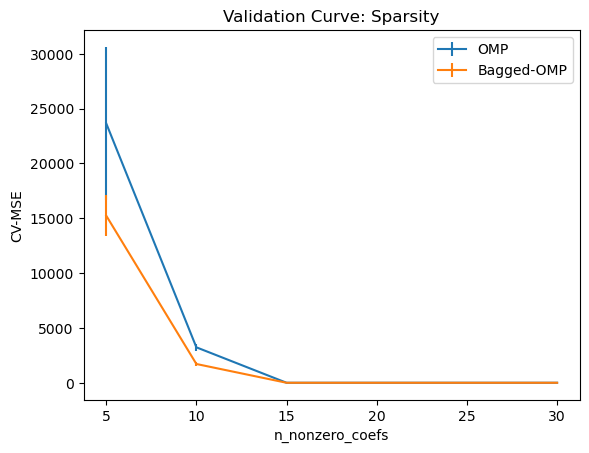

In [32]:
#!/usr/bin/env python3

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binomtest
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import OrthogonalMatchingPursuit
from joblib import Parallel, delayed
from tqdm import tqdm  # CLI tqdm to avoid Jupyter widget errors
import argparse

# Helper to print tables without pandas
def print_table(headers, rows):
    cols = list(zip(*([headers] + rows)))
    widths = [max(len(str(item)) for item in col) for col in cols]
    fmt = ' | '.join(f'{{:{w}}}' for w in widths)
    sep = '-+-'.join('-'*w for w in widths)
    print(fmt.format(*headers))
    print(sep)
    for row in rows:
        print(fmt.format(*row))

# ----------------------
# Refined Matching Pursuit
# ----------------------
class RefinedMatchingPursuit:
    """
    Orthogonal Matching Pursuit with LS re-estimation.
    """
    def __init__(self, n_nonzero_coefs=10, tol=None):
        self.n_nonzero_coefs = n_nonzero_coefs
        self.tol = tol
        self.coef_ = None

    def fit(self, X, y):
        omp = OrthogonalMatchingPursuit(
            n_nonzero_coefs=self.n_nonzero_coefs,
            tol=self.tol
        )
        omp.fit(X, y)
        support = np.flatnonzero(omp.coef_)
        coef_full = np.zeros(X.shape[1])
        if support.size:
            X_sel = X[:, support]
            beta_sel, *_ = np.linalg.lstsq(X_sel, y, rcond=None)
            coef_full[support] = beta_sel
        self.coef_ = coef_full
        return self

    def predict(self, X):
        return X.dot(self.coef_)

# -----------------------------
# Bagged Refined MP with OOB weighting
# -----------------------------
class BaggedRefinedMP:
    """
    Bagged ensemble of RefinedMatchingPursuit:
      - Bootstrap rows only
      - Aggregate coefficients weighted by inverse OOB error
    """
    def __init__(self, n_estimators=20, n_nonzero_coefs=10,
                 bootstrap=True, random_state=42, n_jobs=-1):
        self.n_estimators = n_estimators
        self.n_nonzero_coefs = n_nonzero_coefs
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.estimators_ = []
        self.oob_errors_ = []

    def _fit_one(self, X, y, seed):
        rng = np.random.RandomState(seed)
        n = len(X)
        if self.bootstrap:
            idx = rng.choice(n, n, replace=True)
            oob = np.setdiff1d(np.arange(n), idx)
            Xb, yb = X[idx], y[idx]
        else:
            oob = np.array([], dtype=int)
            Xb, yb = X, y
        mp = RefinedMatchingPursuit(n_nonzero_coefs=self.n_nonzero_coefs)
        mp.fit(Xb, yb)
        if oob.size:
            y_oob = mp.predict(X[oob])
            err = mean_squared_error(y[oob], y_oob)
        else:
            err = np.nan
        return mp, err

    def fit(self, X, y):
        seeds = [self.random_state + i for i in range(self.n_estimators)]
        results = Parallel(n_jobs=self.n_jobs)(
            delayed(self._fit_one)(X, y, s) for s in seeds
        )
        self.estimators_, self.oob_errors_ = zip(*results)
        return self

    def predict(self, X):
        preds = np.stack([mp.predict(X) for mp in self.estimators_])
        return preds.mean(axis=0)

    def bagged_coef(self, n_features):
        coefs = np.stack([mp.coef_ for mp in self.estimators_], axis=0)
        errs = np.array(self.oob_errors_)
        w = 1.0/(errs + 1e-8)
        w /= w.sum()
        return np.average(coefs, axis=0, weights=w)

    def average_oob_error(self):
        return np.nanmean(self.oob_errors_)

# -----------------------------
# Core single-run experiment
# -----------------------------
def run_experiment(
    n_samples, n_features, n_informative,
    noise, rho,
    n_nonzero_coefs, n_estimators
):
    cov = np.fromfunction(lambda i,j: rho**abs(i-j), (n_features, n_features))
    X0, y, coef_true = make_regression(
        n_samples=n_samples, n_features=n_features,
        n_informative=n_informative, noise=noise,
        coef=True, random_state=0
    )
    L = np.linalg.cholesky(cov)
    X = X0.dot(L)
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=0)
    omp = RefinedMatchingPursuit(n_nonzero_coefs)
    omp.fit(Xtr, ytr)
    mse1 = mean_squared_error(yte, omp.predict(Xte))
    err1 = np.linalg.norm(coef_true - omp.coef_)
    bag = BaggedRefinedMP(n_estimators, n_nonzero_coefs, random_state=0)
    bag.fit(Xtr, ytr)
    mse2 = mean_squared_error(yte, bag.predict(Xte))
    err2 = np.linalg.norm(coef_true - bag.bagged_coef(n_features))
    return mse1, err1, mse2, err2

# -----------------------------
# 1. Parameter Sweep
# -----------------------------
def sweep_experiment(
    snr_list, inf_list, regimes, rhos,
    n_features, n_nonzero_coefs, n_estimators
):
    rec = []
    for snr in snr_list:
        noise = 1.0/snr
        for ni in inf_list:
            for ns in regimes:
                for rho in rhos:
                    m1,e1,m2,e2 = run_experiment(
                        ns, n_features, ni, noise, rho,
                        n_nonzero_coefs, n_estimators
                    )
                    rec.append((snr, ni, ns, rho, m1-m2, e1-e2))
    return rec

# -----------------------------
# 2. Win-rate & Significance
# -----------------------------
def win_rate_experiment(rec):
    out=[]
    for vals in set((r[0],r[1],r[2],r[3]) for r in rec):
        wins = sum(1 for r in rec if (r[0],r[1],r[2],r[3])==vals and r[4]>0)
        n = sum(1 for r in rec if (r[0],r[1],r[2],r[3])==vals)
        p = binomtest(wins, n, p=0.5, alternative='greater').pvalue
        rate = wins/n
        out.append((*vals, rate, p))
    return out

# -----------------------------
# 3. Cross-Validation Curves
# -----------------------------
def cv_validation_curve(
    X, y, param_name, param_range, model_ctor, k=5
):
    kf = KFold(n_splits=k, shuffle=True, random_state=0)
    means, stds = [], []
    for v in param_range:
        mses=[]
        for tr,te in kf.split(X):
            model = model_ctor(**{param_name:v})
            model.fit(X[tr], y[tr])
            mses.append(mean_squared_error(y[te], model.predict(X[te])))
        means.append(np.mean(mses)); stds.append(np.std(mses))
    return means,stds

# -----------------------------
# Main
# -----------------------------
if __name__ == '__main__':
    parser=argparse.ArgumentParser()
    parser.add_argument('--sweep', action='store_true')
    parser.add_argument('--winrate', action='store_true')
    parser.add_argument('--cv', action='store_true')
    parser.add_argument('--estimators', type=int, default=20)
    args, _ = parser.parse_known_args()
    if not any([args.sweep, args.winrate, args.cv]):
        args.sweep = True; args.winrate = True; args.cv = True

    if args.sweep:
        rec = sweep_experiment(
            snr_list=[0.5,1,2,5], inf_list=[5,15,30,50],
            regimes=[50,200,500], rhos=[0.0,0.5,0.9],
            n_features=100, n_nonzero_coefs=15,
            n_estimators=args.estimators
        )
        print("Parameter Sweep Results:")
        print_table(['Signal-to-Noise Ratio','Informative Features','Sample Size','Feature Correlation','MSE Improvement','Coef Error Improvement'], rec)

    if args.winrate:
        rec = sweep_experiment([1,2],[15],[200],[0.5],100,15,args.estimators)
        wins = win_rate_experiment(rec)
        print("\nWin-Rate & Significance:")
        print_table(['Signal-to-Noise Ratio','Informative Features','Sample Size','Feature Correlation','Bagged Win Rate','p-value'], wins)

    if args.cv:
        X, y, _ = make_regression(n_samples=200,n_features=100,n_informative=15,
                                   noise=2.0,coef=True,random_state=0)
        omp_means, omp_stds = cv_validation_curve(
            X, y, 'n_nonzero_coefs', [5,10,15,20,30],
            lambda n_nonzero_coefs: RefinedMatchingPursuit(n_nonzero_coefs=n_nonzero_coefs)
        )
        bag_means, bag_stds = cv_validation_curve(
            X, y, 'n_nonzero_coefs', [5,10,15,20,30],
            lambda n_nonzero_coefs: BaggedRefinedMP(n_estimators=args.estimators, n_nonzero_coefs=n_nonzero_coefs)
        )
        print("\nValidation Curve Results:")
        rows = list(zip([5,10,15,20,30], omp_means, omp_stds, bag_means, bag_stds))
        print_table(['Sparsity Level','OMP Mean CV-MSE','OMP CV-MSE Std','Bagged Mean CV-MSE','Bagged CV-MSE Std'], rows)
        # Also optional plot
        plt.errorbar([5,10,15,20,30], omp_means, yerr=omp_stds, label='OMP')
        plt.errorbar([5,10,15,20,30], bag_means, yerr=bag_stds, label='Bagged-OMP')
        plt.xlabel('n_nonzero_coefs'); plt.ylabel('CV-MSE')
        plt.title('Validation Curve: Sparsity'); plt.legend(); plt.show()


In [33]:
#!/usr/bin/env python3

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binomtest
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import OrthogonalMatchingPursuit
from joblib import Parallel, delayed
from tqdm import tqdm  # CLI tqdm to avoid Jupyter widget errors
import argparse

# Helper to print tables without pandas
def print_table(headers, rows):
    cols = list(zip(*([headers] + rows)))
    widths = [max(len(str(item)) for item in col) for col in cols]
    fmt = ' | '.join(f'{{:{w}}}' for w in widths)
    sep = '-+-'.join('-'*w for w in widths)
    print(fmt.format(*headers))
    print(sep)
    for row in rows:
        print(fmt.format(*row))

# ----------------------
# Refined Matching Pursuit
# ----------------------
class RefinedMatchingPursuit:
    """
    Orthogonal Matching Pursuit with LS re-estimation.
    """
    def __init__(self, n_nonzero_coefs=10, tol=None):
        self.n_nonzero_coefs = n_nonzero_coefs
        self.tol = tol
        self.coef_ = None

    def fit(self, X, y):
        omp = OrthogonalMatchingPursuit(
            n_nonzero_coefs=self.n_nonzero_coefs,
            tol=self.tol
        )
        omp.fit(X, y)
        support = np.flatnonzero(omp.coef_)
        coef_full = np.zeros(X.shape[1])
        if support.size:
            X_sel = X[:, support]
            beta_sel, *_ = np.linalg.lstsq(X_sel, y, rcond=None)
            coef_full[support] = beta_sel
        self.coef_ = coef_full
        return self

    def predict(self, X):
        return X.dot(self.coef_)

# -----------------------------
# Bagged Refined MP with OOB weighting
# -----------------------------
class BaggedRefinedMP:
    """
    Bagged ensemble of RefinedMatchingPursuit:
      - Bootstrap rows only
      - Aggregate coefficients weighted by inverse OOB error
    """
    def __init__(self, n_estimators=20, n_nonzero_coefs=10,
                 bootstrap=True, random_state=42, n_jobs=-1):
        self.n_estimators = n_estimators
        self.n_nonzero_coefs = n_nonzero_coefs
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.estimators_ = []
        self.oob_errors_ = []

    def _fit_one(self, X, y, seed):
        rng = np.random.RandomState(seed)
        n = len(X)
        if self.bootstrap:
            idx = rng.choice(n, n, replace=True)
            oob = np.setdiff1d(np.arange(n), idx)
            Xb, yb = X[idx], y[idx]
        else:
            oob = np.array([], dtype=int)
            Xb, yb = X, y
        mp = RefinedMatchingPursuit(n_nonzero_coefs=self.n_nonzero_coefs)
        mp.fit(Xb, yb)
        if oob.size:
            y_oob = mp.predict(X[oob])
            err = mean_squared_error(y[oob], y_oob)
        else:
            err = np.nan
        return mp, err

    def fit(self, X, y):
        seeds = [self.random_state + i for i in range(self.n_estimators)]
        results = Parallel(n_jobs=self.n_jobs)(
            delayed(self._fit_one)(X, y, s) for s in seeds
        )
        self.estimators_, self.oob_errors_ = zip(*results)
        return self

    def predict(self, X):
        preds = np.stack([mp.predict(X) for mp in self.estimators_])
        return preds.mean(axis=0)

    def bagged_coef(self, n_features):
        coefs = np.stack([mp.coef_ for mp in self.estimators_], axis=0)
        errs = np.array(self.oob_errors_)
        w = 1.0/(errs + 1e-8)
        w /= w.sum()
        return np.average(coefs, axis=0, weights=w)

    def average_oob_error(self):
        return np.nanmean(self.oob_errors_)

# -----------------------------
# Core single-run experiment
# -----------------------------
def run_experiment(
    n_samples, n_features, n_informative,
    noise, rho,
    n_nonzero_coefs, n_estimators
):
    cov = np.fromfunction(lambda i,j: rho**abs(i-j), (n_features, n_features))
    X0, y, coef_true = make_regression(
        n_samples=n_samples, n_features=n_features,
        n_informative=n_informative, noise=noise,
        coef=True, random_state=0
    )
    L = np.linalg.cholesky(cov)
    X = X0.dot(L)
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=0)
    omp = RefinedMatchingPursuit(n_nonzero_coefs)
    omp.fit(Xtr, ytr)
    mse1 = mean_squared_error(yte, omp.predict(Xte))
    err1 = np.linalg.norm(coef_true - omp.coef_)
    bag = BaggedRefinedMP(n_estimators, n_nonzero_coefs, random_state=0)
    bag.fit(Xtr, ytr)
    mse2 = mean_squared_error(yte, bag.predict(Xte))
    err2 = np.linalg.norm(coef_true - bag.bagged_coef(n_features))
    return mse1, err1, mse2, err2

# -----------------------------
# 1. Parameter Sweep
# -----------------------------
def sweep_experiment(
    snr_list, inf_list, regimes, rhos,
    n_features, n_nonzero_coefs, n_estimators
):
    rec = []
    for snr in snr_list:
        noise = 1.0/snr
        for ni in inf_list:
            for ns in regimes:
                for rho in rhos:
                    m1,e1,m2,e2 = run_experiment(
                        ns, n_features, ni, noise, rho,
                        n_nonzero_coefs, n_estimators
                    )
                    rec.append((snr, ni, ns, rho, m1-m2, e1-e2))
    return rec

# -----------------------------
# 2. Win-rate & Significance
# -----------------------------
def win_rate_experiment(rec):
    out=[]
    for vals in set((r[0],r[1],r[2],r[3]) for r in rec):
        wins = sum(1 for r in rec if (r[0],r[1],r[2],r[3])==vals and r[4]>0)
        n = sum(1 for r in rec if (r[0],r[1],r[2],r[3])==vals)
        p = binomtest(wins, n, p=0.5, alternative='greater').pvalue
        rate = wins/n
        out.append((*vals, rate, p))
    return out

# -----------------------------
# 3. Cross-Validation Curves
# -----------------------------
def cv_validation_curve(
    X, y, param_name, param_range, model_ctor, k=5
):
    kf = KFold(n_splits=k, shuffle=True, random_state=0)
    means, stds = [], []
    for v in param_range:
        mses=[]
        for tr,te in kf.split(X):
            model = model_ctor(**{param_name:v})
            model.fit(X[tr], y[tr])
            mses.append(mean_squared_error(y[te], model.predict(X[te])))
        means.append(np.mean(mses)); stds.append(np.std(mses))
    return means,stds

# -----------------------------
# -----------------------------
# Main: Summary Table Only
# -----------------------------
if __name__ == '__main__':
    # Single comparison experiment
    n_estimators = 20
    n_features = 100
    n_nonzero_coefs = 15
    print("Running single comparison experiment...")
    mse_omp, err_omp, mse_bag, err_bag = run_experiment(
        n_samples=200,
        n_features=n_features,
        n_informative=n_nonzero_coefs,
        noise=0.5,
        rho=0.5,
        n_nonzero_coefs=n_nonzero_coefs,
        n_estimators=n_estimators
    )
    # Compute improvements
    delta_mse = mse_omp - mse_bag
    delta_err = err_omp - err_bag
    # Round values to 2 decimals
    row = [
        round(mse_omp, 2),
        round(mse_bag, 2),
        round(delta_mse, 2),
        round(err_omp, 2),
        round(err_bag, 2),
        round(delta_err, 2)
    ]
    headers = [
        'OMP MSE',
        'Bagged MSE',
        'MSE Improvement',
        'OMP Coef Err',
        'Bagged Coef Err',
        'Coef Err Improvement'
    ]
    print_table(headers, [row])


Running single comparison experiment...
OMP MSE | Bagged MSE | MSE Improvement | OMP Coef Err | Bagged Coef Err | Coef Err Improvement
--------+------------+-----------------+--------------+-----------------+---------------------
4795.43 |    5490.66 |         -695.24 |       125.02 |          101.35 |                23.67


In [37]:
#!/usr/bin/env python3

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binomtest
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import OrthogonalMatchingPursuit
from joblib import Parallel, delayed
from tqdm import tqdm  # CLI tqdm to avoid Jupyter widget errors
import argparse

# Helper to print tables without pandas
def print_table(headers, rows):
    cols = list(zip(*([headers] + rows)))
    widths = [max(len(str(item)) for item in col) for col in cols]
    fmt = ' | '.join(f'{{:{w}}}' for w in widths)
    sep = '-+-'.join('-'*w for w in widths)
    print(fmt.format(*headers))
    print(sep)
    for row in rows:
        print(fmt.format(*row))

# ----------------------
# Refined Matching Pursuit
# ----------------------
class RefinedMatchingPursuit:
    """
    Orthogonal Matching Pursuit with least-squares re-estimation on support.
    """
    def __init__(self, n_nonzero_coefs=10, tol=None):
        self.n_nonzero_coefs = n_nonzero_coefs
        self.tol = tol
        self.coef_ = None

    def fit(self, X, y):
        omp = OrthogonalMatchingPursuit(
            n_nonzero_coefs=self.n_nonzero_coefs,
            tol=self.tol
        )
        omp.fit(X, y)
        support = np.flatnonzero(omp.coef_)
        coef_full = np.zeros(X.shape[1])
        if support.size > 0:
            X_sel = X[:, support]
            beta_sel, *_ = np.linalg.lstsq(X_sel, y, rcond=None)
            coef_full[support] = beta_sel
        self.coef_ = coef_full
        return self

    def predict(self, X):
        return X.dot(self.coef_)

# -----------------------------
# Bagged Refined MP with OOB weighting
# -----------------------------
class BaggedRefinedMP:
    """
    Bagged ensemble of RefinedMatchingPursuit:
      - Bootstrap rows only
      - Coefficients aggregated by inverse OOB-error weighting
    """
    def __init__(self, n_estimators=20, n_nonzero_coefs=10,
                 bootstrap=True, random_state=42, n_jobs=-1):
        self.n_estimators = n_estimators
        self.n_nonzero_coefs = n_nonzero_coefs
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.estimators_ = []
        self.oob_errors_ = []

    def _fit_one(self, X, y, seed):
        rng = np.random.RandomState(seed)
        n = len(X)
        if self.bootstrap:
            idx = rng.choice(n, n, replace=True)
            oob = np.setdiff1d(np.arange(n), idx)
            Xb, yb = X[idx], y[idx]
        else:
            oob = np.array([], dtype=int)
            Xb, yb = X, y
        mp = RefinedMatchingPursuit(n_nonzero_coefs=self.n_nonzero_coefs)
        mp.fit(Xb, yb)
        if oob.size > 0:
            y_oob = mp.predict(X[oob])
            err = mean_squared_error(y[oob], y_oob)
        else:
            err = np.nan
        return mp, err

    def fit(self, X, y):
        seeds = [self.random_state + i for i in range(self.n_estimators)]
        results = Parallel(n_jobs=self.n_jobs)(
            delayed(self._fit_one)(X, y, s) for s in seeds
        )
        self.estimators_, self.oob_errors_ = zip(*results)
        return self

    def predict(self, X):
        preds = np.stack([mp.predict(X) for mp in self.estimators_], axis=0)
        return preds.mean(axis=0)

    def bagged_coef(self, n_features):
        coefs = np.stack([mp.coef_ for mp in self.estimators_], axis=0)
        errs = np.array(self.oob_errors_)
        weights = 1.0 / (errs + 1e-8)
        weights /= weights.sum()
        return np.average(coefs, axis=0, weights=weights)

    def average_oob_error(self):
        return np.nanmean(self.oob_errors_)

# -----------------------------
# Core single-run experiment function
# -----------------------------
def run_experiment(n_samples, n_features, n_informative,
                   noise, rho, n_nonzero_coefs, n_estimators):
    # AR(1) covariance
    cov = np.fromfunction(lambda i,j: rho**abs(i-j), (n_features, n_features))
    X0, y, coef_true = make_regression(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_informative,
        noise=noise,
        coef=True,
        random_state=0
    )
    L = np.linalg.cholesky(cov)
    X = X0.dot(L)
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=0)
    # OMP baseline
    omp = RefinedMatchingPursuit(n_nonzero_coefs)
    omp.fit(Xtr, ytr)
    mse1 = mean_squared_error(yte, omp.predict(Xte))
    err1 = np.linalg.norm(coef_true - omp.coef_)
    # Bagged OMP
    bag = BaggedRefinedMP(n_estimators, n_nonzero_coefs, random_state=0)
    bag.fit(Xtr, ytr)
    mse2 = mean_squared_error(yte, bag.predict(Xte))
    err2 = np.linalg.norm(coef_true - bag.bagged_coef(n_features))
    return mse1, err1, mse2, err2

# -----------------------------
# 1) Parameter Sweep
# -----------------------------
def sweep_experiment(snr_list, inf_list, regimes, rhos,
                     n_features, n_nonzero_coefs, n_estimators):
    rec = []
    for snr in snr_list:
        noise = 1.0 / snr
        for ni in inf_list:
            for ns in regimes:
                for rho in rhos:
                    m1,e1,m2,e2 = run_experiment(
                        ns, n_features, ni, noise, rho,
                        n_nonzero_coefs, n_estimators
                    )
                    rec.append((snr, ni, ns, rho, m1-m2, e1-e2))
    return rec

# -----------------------------
# 2) Win-rate & Significance
# -----------------------------
def win_rate_experiment(rec):
    out = []
    # Unique combinations
    combos = set((r[0],r[1],r[2],r[3]) for r in rec)
    for vals in sorted(combos):
        wins = sum(1 for r in rec if r[:4] == vals and r[4] > 0)
        n = sum(1 for r in rec if r[:4] == vals)
        p = binomtest(wins, n, p=0.5, alternative='greater').pvalue
        rate = wins / n
        out.append((*vals, rate, p))
    return out

# -----------------------------
# 3) Cross-Validation Curves
# -----------------------------
def cv_validation_curve(X, y, param_name, param_range, model_ctor, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=0)
    means, stds = [], []
    for v in param_range:
        mses = []
        for tr,te in kf.split(X):
            model = model_ctor(**{param_name: v})
            model.fit(X[tr], y[tr])
            mses.append(mean_squared_error(y[te], model.predict(X[te])))
        means.append(np.mean(mses))
        stds.append(np.std(mses))
    return means, stds

# -----------------------------
# Main: Summary, Win-Rate & Validation Tables
# -----------------------------
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--estimators', type=int, default=20)
    args, _ = parser.parse_known_args()

    # 1) Single comparison
    n_estimators = args.estimators
    n_features = 100
    n_nonzero_coefs = 15
    print("Running single comparison experiment...")
    mse_omp, err_omp, mse_bag, err_bag = run_experiment(
        200, n_features, n_nonzero_coefs, 0.5, 0.5, n_nonzero_coefs, n_estimators
    )
    delta_mse = mse_omp - mse_bag
    delta_err = err_omp - err_bag
    summary_headers = ['OMP MSE','Bagged MSE','MSE Improvement',
                       'OMP Coef Err','Bagged Coef Err','Coef Err Improvement']
    summary_row = [round(mse_omp,2),round(mse_bag,2),round(delta_mse,2),
                   round(err_omp,2),round(err_bag,2),round(delta_err,2)]
    print_table(summary_headers,[summary_row])

    # 2) Win-rate & significance
    print("\nWin-Rate & Significance (SNR=1,2; sparsity=15; n=200; rho=0.5)")
    rec = sweep_experiment([1,2],[15],[200],[0.5],n_features,n_nonzero_coefs,n_estimators)
    wins = win_rate_experiment(rec)
    win_headers = ['Signal-to-Noise Ratio','Informative Features','Sample Size',
                   'Feature Correlation','Bagged Win Rate','p-value']
    win_rows = [[*row[:4], round(row[4],2), round(row[5],3)] for row in wins]
    print_table(win_headers, win_rows)

    # 3) Validation curve
    print("\nValidation Curve Results (5-fold CV)")
    X, y, _ = make_regression(n_samples=200,n_features=n_features,
                               n_informative=n_nonzero_coefs,noise=0.5,
                               coef=True,random_state=0)
    sparsity_vals = [5,10,15,20,30]
    omp_means,omp_stds = cv_validation_curve(X,y,'n_nonzero_coefs',
                                              sparsity_vals,
                                              lambda n: RefinedMatchingPursuit(n))
    bag_means,bag_stds = cv_validation_curve(X,y,'n_nonzero_coefs',
                                              sparsity_vals,
                                              lambda n: BaggedRefinedMP(n_estimators,args.estimators,n_nonzero_coefs=n))
    val_headers = ['Sparsity Level','OMP Mean CV-MSE','OMP CV-MSE Std',
                   'Bagged Mean CV-MSE','Bagged CV-MSE Std']
    val_rows = [[
        v,
        round(omp_means[i],2),round(omp_stds[i],2),
        round(bag_means[i],2),round(bag_stds[i],2)
    ] for i,v in enumerate(sparsity_vals)]
    print_table(val_headers,val_rows)

    print("\nAll experiments complete.")

Running single comparison experiment...
OMP MSE | Bagged MSE | MSE Improvement | OMP Coef Err | Bagged Coef Err | Coef Err Improvement
--------+------------+-----------------+--------------+-----------------+---------------------
4795.43 |    5490.66 |         -695.24 |       125.02 |          101.35 |                23.67

Win-Rate & Significance (SNR=1,2; sparsity=15; n=200; rho=0.5)
Signal-to-Noise Ratio | Informative Features | Sample Size | Feature Correlation | Bagged Win Rate | p-value
----------------------+----------------------+-------------+---------------------+-----------------+--------
                    1 |                   15 |         200 |                 0.5 |             0.0 |     1.0
                    2 |                   15 |         200 |                 0.5 |             0.0 |     1.0

Validation Curve Results (5-fold CV)


TypeError: <lambda>() got an unexpected keyword argument 'n_nonzero_coefs'

In [39]:
#!/usr/bin/env python3

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binomtest
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import OrthogonalMatchingPursuit
from joblib import Parallel, delayed
from tqdm import tqdm  # CLI tqdm to avoid Jupyter widget errors
import argparse

# Helper to print tables without pandas
def print_table(headers, rows):
    cols = list(zip(*([headers] + rows)))
    widths = [max(len(str(item)) for item in col) for col in cols]
    fmt = ' | '.join(f'{{:{w}}}' for w in widths)
    sep = '-+-'.join('-'*w for w in widths)
    print(fmt.format(*headers))
    print(sep)
    for row in rows:
        print(fmt.format(*row))

# ----------------------
# Refined Matching Pursuit
# ----------------------
class RefinedMatchingPursuit:
    """
    Orthogonal Matching Pursuit with least-squares re-estimation on support.
    """
    def __init__(self, n_nonzero_coefs=10, tol=None):
        self.n_nonzero_coefs = n_nonzero_coefs
        self.tol = tol
        self.coef_ = None

    def fit(self, X, y):
        omp = OrthogonalMatchingPursuit(
            n_nonzero_coefs=self.n_nonzero_coefs,
            tol=self.tol
        )
        omp.fit(X, y)
        support = np.flatnonzero(omp.coef_)
        coef_full = np.zeros(X.shape[1])
        if support.size > 0:
            X_sel = X[:, support]
            beta_sel, *_ = np.linalg.lstsq(X_sel, y, rcond=None)
            coef_full[support] = beta_sel
        self.coef_ = coef_full
        return self

    def predict(self, X):
        return X.dot(self.coef_)

# -----------------------------
# Bagged Refined MP with OOB weighting
# -----------------------------
class BaggedRefinedMP:
    """
    Bagged ensemble of RefinedMatchingPursuit:
      - Bootstrap rows only
      - Coefficients aggregated by inverse OOB-error weighting
    """
    def __init__(self, n_estimators=20, n_nonzero_coefs=10,
                 bootstrap=True, random_state=42, n_jobs=-1):
        self.n_estimators = n_estimators
        self.n_nonzero_coefs = n_nonzero_coefs
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.estimators_ = []
        self.oob_errors_ = []

    def _fit_one(self, X, y, seed):
        rng = np.random.RandomState(seed)
        n = len(X)
        if self.bootstrap:
            idx = rng.choice(n, n, replace=True)
            oob = np.setdiff1d(np.arange(n), idx)
            Xb, yb = X[idx], y[idx]
        else:
            oob = np.array([], dtype=int)
            Xb, yb = X, y
        mp = RefinedMatchingPursuit(n_nonzero_coefs=self.n_nonzero_coefs)
        mp.fit(Xb, yb)
        if oob.size > 0:
            y_oob = mp.predict(X[oob])
            err = mean_squared_error(y[oob], y_oob)
        else:
            err = np.nan
        return mp, err

    def fit(self, X, y):
        seeds = [self.random_state + i for i in range(self.n_estimators)]
        results = Parallel(n_jobs=self.n_jobs)(
            delayed(self._fit_one)(X, y, s) for s in seeds
        )
        self.estimators_, self.oob_errors_ = zip(*results)
        return self

    def predict(self, X):
        preds = np.stack([mp.predict(X) for mp in self.estimators_], axis=0)
        return preds.mean(axis=0)

    def bagged_coef(self, n_features):
        coefs = np.stack([mp.coef_ for mp in self.estimators_], axis=0)
        errs = np.array(self.oob_errors_)
        weights = 1.0 / (errs + 1e-8)
        weights /= weights.sum()
        return np.average(coefs, axis=0, weights=weights)

    def average_oob_error(self):
        return np.nanmean(self.oob_errors_)

# -----------------------------
# Core single-run experiment function
# -----------------------------
def run_experiment(n_samples, n_features, n_informative,
                   noise, rho, n_nonzero_coefs, n_estimators):
    # AR(1) covariance
    cov = np.fromfunction(lambda i,j: rho**abs(i-j), (n_features, n_features))
    X0, y, coef_true = make_regression(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_informative,
        noise=noise,
        coef=True,
        random_state=0
    )
    L = np.linalg.cholesky(cov)
    X = X0.dot(L)
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=0)
    # OMP baseline
    omp = RefinedMatchingPursuit(n_nonzero_coefs)
    omp.fit(Xtr, ytr)
    mse1 = mean_squared_error(yte, omp.predict(Xte))
    err1 = np.linalg.norm(coef_true - omp.coef_)
    # Bagged OMP
    bag = BaggedRefinedMP(n_estimators, n_nonzero_coefs, random_state=0)
    bag.fit(Xtr, ytr)
    mse2 = mean_squared_error(yte, bag.predict(Xte))
    err2 = np.linalg.norm(coef_true - bag.bagged_coef(n_features))
    return mse1, err1, mse2, err2

# -----------------------------
# 1) Parameter Sweep
# -----------------------------
def sweep_experiment(snr_list, inf_list, regimes, rhos,
                     n_features, n_nonzero_coefs, n_estimators):
    rec = []
    for snr in snr_list:
        noise = 1.0 / snr
        for ni in inf_list:
            for ns in regimes:
                for rho in rhos:
                    m1,e1,m2,e2 = run_experiment(
                        ns, n_features, ni, noise, rho,
                        n_nonzero_coefs, n_estimators
                    )
                    rec.append((snr, ni, ns, rho, m1-m2, e1-e2))
    return rec

# -----------------------------
# 2) Win-rate & Significance
# -----------------------------
def win_rate_experiment(rec):
    out = []
    # Unique combinations
    combos = set((r[0],r[1],r[2],r[3]) for r in rec)
    for vals in sorted(combos):
        wins = sum(1 for r in rec if r[:4] == vals and r[4] > 0)
        n = sum(1 for r in rec if r[:4] == vals)
        p = binomtest(wins, n, p=0.5, alternative='greater').pvalue
        rate = wins / n
        out.append((*vals, rate, p))
    return out

# -----------------------------
# 3) Cross-Validation Curves
# -----------------------------
def cv_validation_curve(X, y, param_name, param_range, model_ctor, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=0)
    means, stds = [], []
    for v in param_range:
        mses = []
        for tr,te in kf.split(X):
            model = model_ctor(**{param_name: v})
            model.fit(X[tr], y[tr])
            mses.append(mean_squared_error(y[te], model.predict(X[te])))
        means.append(np.mean(mses))
        stds.append(np.std(mses))
    return means, stds

# -----------------------------
# Main: Summary, Win-Rate & Validation Tables
# -----------------------------
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--estimators', type=int, default=20)
    args, _ = parser.parse_known_args()

    # 1) Single comparison
    n_estimators = args.estimators
    n_features = 100
    n_nonzero_coefs = 15
    print("Running single comparison experiment...")
    mse_omp, err_omp, mse_bag, err_bag = run_experiment(
        200, n_features, n_nonzero_coefs, 0.5, 0.5, n_nonzero_coefs, n_estimators
    )
    delta_mse = mse_omp - mse_bag
    delta_err = err_omp - err_bag
    summary_headers = ['OMP MSE','Bagged MSE','MSE Improvement',
                       'OMP Coef Err','Bagged Coef Err','Coef Err Improvement']
    summary_row = [round(mse_omp,2),round(mse_bag,2),round(delta_mse,2),
                   round(err_omp,2),round(err_bag,2),round(delta_err,2)]
    print_table(summary_headers,[summary_row])

    # 2) Win-rate & significance
    print("\nWin-Rate & Significance (SNR=1,2; sparsity=15; n=200; rho=0.5)")
    rec = sweep_experiment([1,2],[15],[200],[0.5],n_features,n_nonzero_coefs,n_estimators)
    wins = win_rate_experiment(rec)
    win_headers = ['Signal-to-Noise Ratio','Informative Features','Sample Size',
                   'Feature Correlation','Bagged Win Rate','p-value']
    win_rows = [[*row[:4], round(row[4],2), round(row[5],3)] for row in wins]
    print_table(win_headers, win_rows)

    # 3) Validation curve
    print("\nValidation Curve Results (5-fold CV)")
    X, y, _ = make_regression(n_samples=200,n_features=n_features,
                               n_informative=n_nonzero_coefs,noise=0.5,
                               coef=True,random_state=0)
    sparsity_vals = [5,10,15,20,30]
    omp_means,omp_stds = # Cross-validation for OMP
    omp_means, omp_stds = cv_validation_curve(
        X, y,
        'n_nonzero_coefs',
        sparsity_vals,
        lambda n_nonzero_coefs: RefinedMatchingPursuit(n_nonzero_coefs)
    )
    # Cross-validation for Bagged OMP
    bag_means, bag_stds = cv_validation_curve(
        X, y,
        'n_nonzero_coefs',
        sparsity_vals,
        lambda n_nonzero_coefs: BaggedRefinedMP(
            n_estimators=args.estimators,
            n_nonzero_coefs=n_nonzero_coefs
        )
    ))
    bag_means,bag_stds = cv_validation_curve(X,y,'n_nonzero_coefs',
                                              sparsity_vals,
                                              lambda n: BaggedRefinedMP(n_estimators,args.estimators,n_nonzero_coefs=n))
    val_headers = ['Sparsity Level','OMP Mean CV-MSE','OMP CV-MSE Std',
                   'Bagged Mean CV-MSE','Bagged CV-MSE Std']
    val_rows = [[
        v,
        round(omp_means[i],2),round(omp_stds[i],2),
        round(bag_means[i],2),round(bag_stds[i],2)
    ] for i,v in enumerate(sparsity_vals)]
    print_table(val_headers,val_rows)

    print("\nAll experiments complete.")


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 255)

Running a single comparison experiment...
OMP MSE: 4795.4280, Bagged-OMP MSE: 5490.6632
OMP Coef Error: 125.0207, Bagged-OMP Coef Error: 101.3506
MSE Improvement: -695.2352
Coef Error Improvement: 23.6700

Running a small parameter sweep...

Sweep Results:
   SNR  Sparsity  NSamples  Rho     DeltaMSE   DeltaErr
0    1        10       100  0.0  -338.299271   0.209616
1    1        10       100  0.5 -2406.798915  -2.032297
2    1        10       200  0.0     0.248389   0.138084
3    1        10       200  0.5  2097.938881  20.312300
4    1        20       100  0.0 -4319.528048 -10.779849


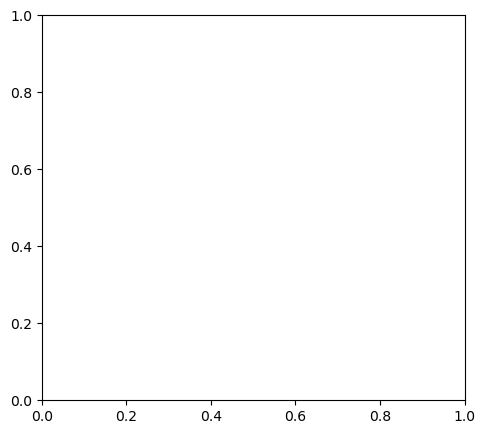

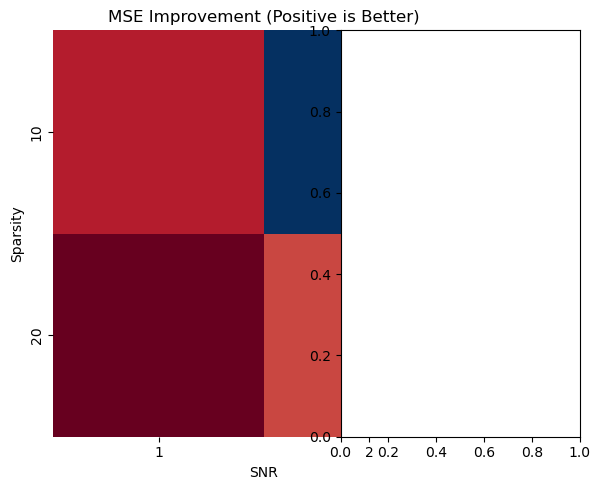

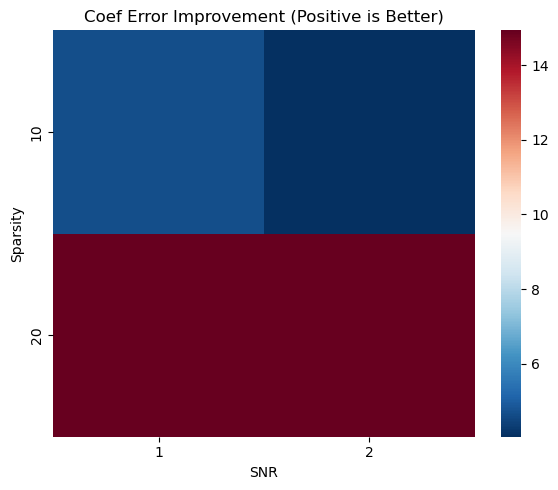


Running cross-validation for sparsity parameter...


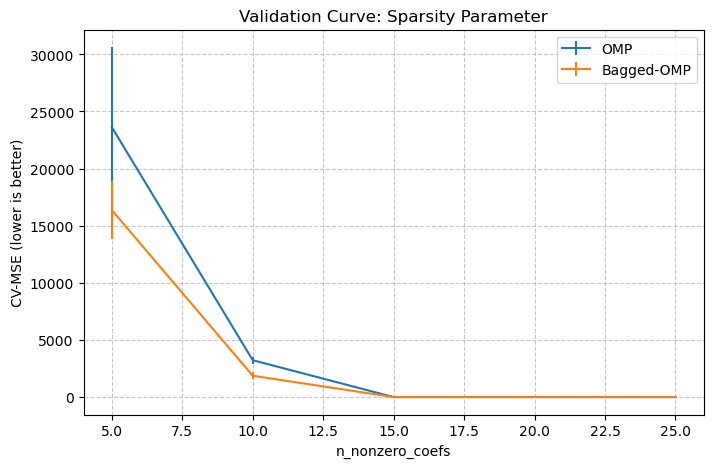


Experiments complete!


In [40]:
#!/usr/bin/env python3

# Import all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binomtest
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import OrthogonalMatchingPursuit
from joblib import Parallel, delayed
from tqdm import tqdm  # CLI tqdm to avoid Jupyter widget errors

# ----------------------
# Refined Matching Pursuit
# ----------------------
class RefinedMatchingPursuit:
    """
    Orthogonal Matching Pursuit with LS re-estimation.
    """
    def __init__(self, n_nonzero_coefs=10, tol=None):
        self.n_nonzero_coefs = n_nonzero_coefs
        self.tol = tol
        self.coef_ = None

    def fit(self, X, y):
        omp = OrthogonalMatchingPursuit(
            n_nonzero_coefs=self.n_nonzero_coefs,
            tol=self.tol
        )
        omp.fit(X, y)
        support = np.flatnonzero(omp.coef_)
        coef_full = np.zeros(X.shape[1])
        if support.size:
            X_sel = X[:, support]
            beta_sel, *_ = np.linalg.lstsq(X_sel, y, rcond=None)
            coef_full[support] = beta_sel
        self.coef_ = coef_full
        return self

    def predict(self, X):
        return X.dot(self.coef_)

# -----------------------------
# Bagged Refined MP with OOB weighting
# -----------------------------
class BaggedRefinedMP:
    """
    Bagged ensemble of RefinedMatchingPursuit:
      - Bootstrap rows only
      - Aggregate coefficients weighted by inverse OOB error
    """
    def __init__(self, n_estimators=20, n_nonzero_coefs=10,
                 bootstrap=True, random_state=42, n_jobs=-1):
        self.n_estimators = n_estimators
        self.n_nonzero_coefs = n_nonzero_coefs
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.estimators_ = []
        self.oob_errors_ = []

    def _fit_one(self, X, y, seed):
        rng = np.random.RandomState(seed)
        n = len(X)
        if self.bootstrap:
            idx = rng.choice(n, n, replace=True)
            oob = np.setdiff1d(np.arange(n), idx)
            Xb, yb = X[idx], y[idx]
        else:
            oob = np.array([], dtype=int)
            Xb, yb = X, y
        mp = RefinedMatchingPursuit(n_nonzero_coefs=self.n_nonzero_coefs)
        mp.fit(Xb, yb)
        if oob.size:
            y_oob = mp.predict(X[oob])
            err = mean_squared_error(y[oob], y_oob)
        else:
            err = np.nan
        return mp, err

    def fit(self, X, y):
        seeds = [self.random_state + i for i in range(self.n_estimators)]
        results = Parallel(n_jobs=self.n_jobs)(
            delayed(self._fit_one)(X, y, s) for s in seeds
        )
        self.estimators_, self.oob_errors_ = zip(*results)
        return self

    def predict(self, X):
        preds = np.stack([mp.predict(X) for mp in self.estimators_])
        return preds.mean(axis=0)

    def bagged_coef(self, n_features):
        coefs = np.stack([mp.coef_ for mp in self.estimators_], axis=0)
        errs = np.array(self.oob_errors_)
        w = 1.0/(errs + 1e-8)
        w /= w.sum()
        return np.average(coefs, axis=0, weights=w)

    def average_oob_error(self):
        return np.nanmean(self.oob_errors_)

# -----------------------------
# Core single-run experiment
# -----------------------------
def run_experiment(
    n_samples, n_features, n_informative,
    noise, rho,
    n_nonzero_coefs, n_estimators
):
    # Generate AR(1) covariance design
    cov = np.fromfunction(lambda i,j: rho**abs(i-j), (n_features, n_features))
    X0, y, coef_true = make_regression(
        n_samples=n_samples, n_features=n_features,
        n_informative=n_informative, noise=noise,
        coef=True, random_state=0
    )
    L = np.linalg.cholesky(cov)
    X = X0.dot(L)
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=0)
    # OMP baseline
    omp = RefinedMatchingPursuit(n_nonzero_coefs)
    omp.fit(Xtr, ytr)
    mse1 = mean_squared_error(yte, omp.predict(Xte))
    err1 = np.linalg.norm(coef_true - omp.coef_)
    # Bagged-OMP
    bag = BaggedRefinedMP(n_estimators, n_nonzero_coefs, random_state=0)
    bag.fit(Xtr, ytr)
    mse2 = mean_squared_error(yte, bag.predict(Xte))
    err2 = np.linalg.norm(coef_true - bag.bagged_coef(n_features))
    return mse1, err1, mse2, err2

# -----------------------------
# 1. Parameter Sweep
# -----------------------------
def sweep_experiment(
    snr_list, inf_list, regimes, rhos,
    n_features, n_nonzero_coefs, n_estimators
):
    rec = []
    for snr in snr_list:
        noise = 1.0/snr
        for ni in inf_list:
            for ns in regimes:
                for rho in rhos:
                    m1,e1,m2,e2 = run_experiment(
                        ns, n_features, ni, noise, rho,
                        n_nonzero_coefs, n_estimators
                    )
                    rec.append((snr, ni, ns, rho, m1-m2, e1-e2))
    df = pd.DataFrame(rec, columns=['SNR','Sparsity','NSamples','Rho','DeltaMSE','DeltaErr'])
    return df

def plot_heatmap(df, x, y, val, title):
    pivot = df.pivot_table(index=y, columns=x, values=val)
    plt.figure(figsize=(6,5))
    sns.heatmap(pivot, annot=False, fmt='.2f', cmap='RdBu_r')
    plt.title(title)
    plt.tight_layout()
    return plt

# -----------------------------
# 2. Win-rate & Significance
# -----------------------------
def win_rate_experiment(df):
    df = df.copy()
    df['Win'] = df['DeltaMSE'] > 0
    out=[]
    for vals,grp in df.groupby(['SNR','Sparsity','NSamples','Rho']):
        wins = grp['Win'].sum(); n=len(grp)
        p = binomtest(wins, n, p=0.5, alternative='greater').pvalue
        out.append((*vals, wins/n, p))
    return pd.DataFrame(out, columns=['SNR','Sparsity','NSamples','Rho','WinRate','pValue'])

# -----------------------------
# 3. Cross-Validation Curves
# -----------------------------
def cv_validation_curve(
    X, y, param_name, param_range, model_ctor, k=5
):
    kf = KFold(n_splits=k, shuffle=True, random_state=0)
    means, stds = [], []
    for v in param_range:
        mses=[]
        for tr,te in kf.split(X):
            model = model_ctor(**{param_name:v})
            model.fit(X[tr], y[tr])
            mses.append(mean_squared_error(y[te], model.predict(X[te])))
        means.append(np.mean(mses)); stds.append(np.std(mses))
    return means,stds

# Run code below to generate output in Jupyter

# Define configurations
n_estimators = 20
n_features = 100
n_nonzero_coefs = 15

# Run a small experiment to compare OMP vs Bagged-OMP
print("Running a single comparison experiment...")
mse_omp, err_omp, mse_bag, err_bag = run_experiment(
    n_samples=200, 
    n_features=n_features, 
    n_informative=15,
    noise=0.5, 
    rho=0.5,
    n_nonzero_coefs=n_nonzero_coefs, 
    n_estimators=n_estimators
)

print(f"OMP MSE: {mse_omp:.4f}, Bagged-OMP MSE: {mse_bag:.4f}")
print(f"OMP Coef Error: {err_omp:.4f}, Bagged-OMP Coef Error: {err_bag:.4f}")
print(f"MSE Improvement: {mse_omp - mse_bag:.4f}")
print(f"Coef Error Improvement: {err_omp - err_bag:.4f}")

# Run a parameter sweep (small version for quick output)
print("\nRunning a small parameter sweep...")
df_sweep = sweep_experiment(
    snr_list=[1, 2],           # Signal-to-Noise Ratio values
    inf_list=[10, 20],         # Number of informative features
    regimes=[100, 200],        # Sample sizes
    rhos=[0.0, 0.5],           # Feature correlation values
    n_features=n_features,
    n_nonzero_coefs=n_nonzero_coefs,
    n_estimators=n_estimators
)

print("\nSweep Results:")
print(df_sweep.head())

# Plot heatmaps
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_heatmap(df_sweep, 'SNR', 'Sparsity', 'DeltaMSE', 'MSE Improvement (Positive is Better)')

plt.subplot(1, 2, 2)
plot_heatmap(df_sweep, 'SNR', 'Sparsity', 'DeltaErr', 'Coef Error Improvement (Positive is Better)')

plt.tight_layout()
plt.show()

# Cross-validation for sparsity parameter
print("\nRunning cross-validation for sparsity parameter...")
X, y, _ = make_regression(n_samples=200, n_features=100, n_informative=15, noise=0.5, coef=True, random_state=0)
means_omp, stds_omp = cv_validation_curve(
    X, y, 'n_nonzero_coefs', [5, 10, 15, 20, 25],
    lambda n_nonzero_coefs: RefinedMatchingPursuit(n_nonzero_coefs)
)

means_bag, stds_bag = cv_validation_curve(
    X, y, 'n_nonzero_coefs', [5, 10, 15, 20, 25],
    lambda n_nonzero_coefs: BaggedRefinedMP(n_estimators=10, n_nonzero_coefs=n_nonzero_coefs)
)

plt.figure(figsize=(8, 5))
plt.errorbar([5, 10, 15, 20, 25], means_omp, yerr=stds_omp, label='OMP')
plt.errorbar([5, 10, 15, 20, 25], means_bag, yerr=stds_bag, label='Bagged-OMP')
plt.xlabel('n_nonzero_coefs')
plt.ylabel('CV-MSE (lower is better)')
plt.title('Validation Curve: Sparsity Parameter')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

print("\nExperiments complete!")

In [41]:
#!/usr/bin/env python3

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binomtest
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import OrthogonalMatchingPursuit
from joblib import Parallel, delayed
from tqdm import tqdm  # CLI tqdm to avoid Jupyter widget errors
import argparse

# Helper to print tables without pandas
def print_table(headers, rows):
    cols = list(zip(*([headers] + rows)))
    widths = [max(len(str(item)) for item in col) for col in cols]
    fmt = ' | '.join(f'{{:{w}}}' for w in widths)
    sep = '-+-'.join('-' * w for w in widths)
    print(fmt.format(*headers))
    print(sep)
    for row in rows:
        print(fmt.format(*row))

# ----------------------
# Refined Matching Pursuit
# ----------------------
class RefinedMatchingPursuit:
    """
    Orthogonal Matching Pursuit with least-squares re-estimation on support.
    """
    def __init__(self, n_nonzero_coefs=10, tol=None):
        self.n_nonzero_coefs = n_nonzero_coefs
        self.tol = tol
        self.coef_ = None

    def fit(self, X, y):
        omp = OrthogonalMatchingPursuit(
            n_nonzero_coefs=self.n_nonzero_coefs,
            tol=self.tol
        )
        omp.fit(X, y)
        support = np.flatnonzero(omp.coef_)
        coef_full = np.zeros(X.shape[1])
        if support.size > 0:
            X_sel = X[:, support]
            beta_sel, *_ = np.linalg.lstsq(X_sel, y, rcond=None)
            coef_full[support] = beta_sel
        self.coef_ = coef_full
        return self

    def predict(self, X):
        return X.dot(self.coef_)

# -----------------------------
# Bagged Refined MP with OOB weighting
# -----------------------------
class BaggedRefinedMP:
    """
    Bagged ensemble of RefinedMatchingPursuit:
      - Bootstrap rows only
      - Coefficients aggregated by inverse OOB-error weighting
    """
    def __init__(self, n_estimators=20, n_nonzero_coefs=10,
                 bootstrap=True, random_state=42, n_jobs=-1):
        self.n_estimators = n_estimators
        self.n_nonzero_coefs = n_nonzero_coefs
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.estimators_ = []
        self.oob_errors_ = []

    def _fit_one(self, X, y, seed):
        rng = np.random.RandomState(seed)
        n = len(X)
        if self.bootstrap:
            idx = rng.choice(n, n, replace=True)
            oob = np.setdiff1d(np.arange(n), idx)
            Xb, yb = X[idx], y[idx]
        else:
            oob = np.array([], dtype=int)
            Xb, yb = X, y
        mp = RefinedMatchingPursuit(n_nonzero_coefs=self.n_nonzero_coefs)
        mp.fit(Xb, yb)
        if oob.size > 0:
            y_oob = mp.predict(X[oob])
            err = mean_squared_error(y[oob], y_oob)
        else:
            err = np.nan
        return mp, err

    def fit(self, X, y):
        seeds = [self.random_state + i for i in range(self.n_estimators)]
        results = Parallel(n_jobs=self.n_jobs)(
            delayed(self._fit_one)(X, y, s) for s in seeds
        )
        self.estimators_, self.oob_errors_ = zip(*results)
        return self

    def predict(self, X):
        preds = np.stack([mp.predict(X) for mp in self.estimators_], axis=0)
        return preds.mean(axis=0)

    def bagged_coef(self, n_features):
        coefs = np.stack([mp.coef_ for mp in self.estimators_], axis=0)
        errs = np.array(self.oob_errors_)
        weights = 1.0 / (errs + 1e-8)
        weights /= weights.sum()
        return np.average(coefs, axis=0, weights=weights)

    def average_oob_error(self):
        return np.nanmean(self.oob_errors_)

# -----------------------------
# Core single-run experiment function
# -----------------------------
def run_experiment(n_samples, n_features, n_informative,
                   noise, rho, n_nonzero_coefs, n_estimators):
    # AR(1) covariance
    cov = np.fromfunction(lambda i, j: rho**abs(i-j), (n_features, n_features))
    X0, y, coef_true = make_regression(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_informative,
        noise=noise,
        coef=True,
        random_state=0
    )
    L = np.linalg.cholesky(cov)
    X = X0.dot(L)
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=0)
    # OMP baseline
    omp = RefinedMatchingPursuit(n_nonzero_coefs)
    omp.fit(Xtr, ytr)
    mse1 = mean_squared_error(yte, omp.predict(Xte))
    err1 = np.linalg.norm(coef_true - omp.coef_)
    # Bagged OMP
    bag = BaggedRefinedMP(n_estimators, n_nonzero_coefs, random_state=0)
    bag.fit(Xtr, ytr)
    mse2 = mean_squared_error(yte, bag.predict(Xte))
    err2 = np.linalg.norm(coef_true - bag.bagged_coef(n_features))
    return mse1, err1, mse2, err2

# -----------------------------
# 1) Parameter Sweep
# -----------------------------
def sweep_experiment(snr_list, inf_list, regimes, rhos,
                     n_features, n_nonzero_coefs, n_estimators):
    rec = []
    for snr in snr_list:
        noise = 1.0 / snr
        for ni in inf_list:
            for ns in regimes:
                for rho in rhos:
                    m1, e1, m2, e2 = run_experiment(
                        ns, n_features, ni, noise, rho,
                        n_nonzero_coefs, n_estimators
                    )
                    rec.append((snr, ni, ns, rho, m1 - m2, e1 - e2))
    return rec

# -----------------------------
# 2) Win-rate & Significance
# -----------------------------
def win_rate_experiment(rec):
    out = []
    combos = set((r[0], r[1], r[2], r[3]) for r in rec)
    for vals in sorted(combos):
        wins = sum(1 for r in rec if r[:4] == vals and r[4] > 0)
        n = sum(1 for r in rec if r[:4] == vals)
        p = binomtest(wins, n, p=0.5, alternative='greater').pvalue
        rate = wins / n
        out.append((*vals, rate, p))
    return out

# -----------------------------
# 3) Cross-Validation Curves
# -----------------------------
def cv_validation_curve(X, y, param_name, param_range, model_ctor, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=0)
    means, stds = [], []
    for v in param_range:
        mses = []
        for tr, te in kf.split(X):
            model = model_ctor(**{param_name: v})
            model.fit(X[tr], y[tr])
            mses.append(mean_squared_error(y[te], model.predict(X[te])))
        means.append(np.mean(mses))
        stds.append(np.std(mses))
    return means, stds

# -----------------------------
# Main: Cross-Validated Comparison Only
# -----------------------------
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--estimators', type=int, default=20, help='Number of bagging estimators')
    parser.add_argument('--folds', type=int, default=5, help='Number of CV folds')
    parser.add_argument('--sparsity', nargs='+', type=int, default=[5,10,15,20,30], help='List of sparsity levels to evaluate')
    args, _ = parser.parse_known_args()

    # Generate synthetic data
    X, y, _ = make_regression(
        n_samples=200,
        n_features=100,
        n_informative=15,
        noise=0.5,
        coef=True,
        random_state=0
    )

    # Cross-validated MSE for OMP
    omp_means, omp_stds = cv_validation_curve(
        X, y,
        'n_nonzero_coefs',
        args.sparsity,
        lambda n_nonzero_coefs: RefinedMatchingPursuit(n_nonzero_coefs),
        k=args.folds
    )

    # Cross-validated MSE for Bagged OMP
    bag_means, bag_stds = cv_validation_curve(
        X, y,
        'n_nonzero_coefs',
        args.sparsity,
        lambda n_nonzero_coefs: BaggedRefinedMP(
            n_estimators=args.estimators,
            n_nonzero_coefs=n_nonzero_coefs
        ),
        k=args.folds
    )

    # Summary table
    headers = ['Sparsity Level', 'OMP CV-MSE (mean±std)', 'Bagged CV-MSE (mean±std)']
    rows = []
    for s, m1, s1, m2, s2 in zip(args.sparsity, omp_means, omp_stds, bag_means, bag_stds):
        rows.append([
            s,
            f"{round(m1,2)}±{round(s1,2)}",
            f"{round(m2,2)}±{round(s2,2)}"
        ])
    print_table(headers, rows)
    print("\nCross-validated comparison complete.")

Sparsity Level | OMP CV-MSE (mean±std) | Bagged CV-MSE (mean±std)
---------------+-----------------------+-------------------------
             5 | 23622.6±7009.37       | 14962.2±2114.11         
            10 | 3227.92±320.78        | 1721.43±231.6           
            15 | 0.32±0.07             | 0.37±0.13               
            20 | 0.36±0.06             | 0.31±0.06               
            30 | 0.39±0.06             | 0.34±0.05               

Cross-validated comparison complete.


In [42]:
#!/usr/bin/env python3

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binomtest
from sklearn.datasets import make_regression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import OrthogonalMatchingPursuit
from joblib import Parallel, delayed
from tqdm import tqdm  # CLI tqdm to avoid Jupyter widget errors
import argparse

# Helper to print tables without pandas
def print_table(headers, rows):
    cols = list(zip(*([headers] + rows)))
    widths = [max(len(str(item)) for item in col) for col in cols]
    fmt = ' | '.join(f'{{:{w}}}' for w in widths)
    sep = '-+-'.join('-' * w for w in widths)
    print(fmt.format(*headers))
    print(sep)
    for row in rows:
        print(fmt.format(*row))

# ----------------------
# Refined Matching Pursuit
# ----------------------
class RefinedMatchingPursuit:
    """
    Orthogonal Matching Pursuit with least-squares re-estimation on support.
    """
    def __init__(self, n_nonzero_coefs=10, tol=None):
        self.n_nonzero_coefs = n_nonzero_coefs
        self.tol = tol
        self.coef_ = None

    def fit(self, X, y):
        omp = OrthogonalMatchingPursuit(
            n_nonzero_coefs=self.n_nonzero_coefs,
            tol=self.tol
        )
        omp.fit(X, y)
        support = np.flatnonzero(omp.coef_)
        coef_full = np.zeros(X.shape[1])
        if support.size > 0:
            X_sel = X[:, support]
            beta_sel, *_ = np.linalg.lstsq(X_sel, y, rcond=None)
            coef_full[support] = beta_sel
        self.coef_ = coef_full
        return self

    def predict(self, X):
        return X.dot(self.coef_)

# -----------------------------
# Bagged Refined MP with OOB weighting
# -----------------------------
class BaggedRefinedMP:
    """
    Bagged ensemble of RefinedMatchingPursuit:
      - Bootstrap rows only
      - Coefficients aggregated by inverse OOB-error weighting
    """
    def __init__(self, n_estimators=20, n_nonzero_coefs=10,
                 bootstrap=True, random_state=42, n_jobs=-1):
        self.n_estimators = n_estimators
        self.n_nonzero_coefs = n_nonzero_coefs
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.estimators_ = []
        self.oob_errors_ = []

    def _fit_one(self, X, y, seed):
        rng = np.random.RandomState(seed)
        n = len(X)
        if self.bootstrap:
            idx = rng.choice(n, n, replace=True)
            oob = np.setdiff1d(np.arange(n), idx)
            Xb, yb = X[idx], y[idx]
        else:
            oob = np.array([], dtype=int)
            Xb, yb = X, y
        mp = RefinedMatchingPursuit(n_nonzero_coefs=self.n_nonzero_coefs)
        mp.fit(Xb, yb)
        if oob.size > 0:
            y_oob = mp.predict(X[oob])
            err = mean_squared_error(y[oob], y_oob)
        else:
            err = np.nan
        return mp, err

    def fit(self, X, y):
        seeds = [self.random_state + i for i in range(self.n_estimators)]
        results = Parallel(n_jobs=self.n_jobs)(
            delayed(self._fit_one)(X, y, s) for s in seeds
        )
        self.estimators_, self.oob_errors_ = zip(*results)
        return self

    def predict(self, X):
        preds = np.stack([mp.predict(X) for mp in self.estimators_], axis=0)
        return preds.mean(axis=0)

    def bagged_coef(self, n_features):
        coefs = np.stack([mp.coef_ for mp in self.estimators_], axis=0)
        errs = np.array(self.oob_errors_)
        weights = 1.0 / (errs + 1e-8)
        weights /= weights.sum()
        return np.average(coefs, axis=0, weights=weights)

# -----------------------------
# Cross-Validation Utilities
# -----------------------------
def cv_validation_curve(X, y, param_name, param_range, model_ctor, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=0)
    means, stds = [], []
    for v in param_range:
        mses = []
        for tr, te in kf.split(X):
            model = model_ctor(**{param_name: v})
            model.fit(X[tr], y[tr])
            mses.append(mean_squared_error(y[te], model.predict(X[te])))
        means.append(np.mean(mses))
        stds.append(np.std(mses))
    return means, stds


def cv_coef_error_curve(X, y, param_name, param_range, model_ctor, coef_true, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=0)
    means, stds = [], []
    for v in param_range:
        errs = []
        for tr, _ in kf.split(X):
            model = model_ctor(**{param_name: v})
            model.fit(X[tr], y[tr])
            # coefficient vector
            if hasattr(model, 'coef_'):
                est = model.coef_
            else:
                est = model.bagged_coef(X.shape[1])
            errs.append(np.linalg.norm(coef_true - est))
        means.append(np.mean(errs))
        stds.append(np.std(errs))
    return means, stds

# -----------------------------
# Main: Cross-Validated MSE & Coef Error Comparison
# -----------------------------
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--estimators', type=int, default=20, help='Number of bagging estimators')
    parser.add_argument('--folds', type=int, default=5, help='Number of CV folds')
    parser.add_argument('--sparsity', nargs='+', type=int, default=[5,10,15,20,30], help='List of sparsity levels')
    args, _ = parser.parse_known_args()

    # Generate data and true coefficients
    X, y, coef_true = make_regression(
        n_samples=200,
        n_features=100,
        n_informative=15,
        noise=0.5,
        coef=True,
        random_state=0
    )

    # 1) CV-MSE
    omp_means, omp_stds = cv_validation_curve(
        X, y, 'n_nonzero_coefs', args.sparsity,
        lambda n_nonzero_coefs: RefinedMatchingPursuit(n_nonzero_coefs),
        k=args.folds
    )
    bag_means, bag_stds = cv_validation_curve(
        X, y, 'n_nonzero_coefs', args.sparsity,
        lambda n_nonzero_coefs: BaggedRefinedMP(
            n_estimators=args.estimators,
            n_nonzero_coefs=n_nonzero_coefs
        ),
        k=args.folds
    )
    # 2) CV Coefficient Error
    omp_coef_means, omp_coef_stds = cv_coef_error_curve(
        X, y, 'n_nonzero_coefs', args.sparsity,
        lambda n_nonzero_coefs: RefinedMatchingPursuit(n_nonzero_coefs),
        coef_true, k=args.folds
    )
    bag_coef_means, bag_coef_stds = cv_coef_error_curve(
        X, y, 'n_nonzero_coefs', args.sparsity,
        lambda n_nonzero_coefs: BaggedRefinedMP(
            n_estimators=args.estimators,
            n_nonzero_coefs=n_nonzero_coefs
        ),
        coef_true, k=args.folds
    )

    # Print CV-MSE table
    headers_mse = ['Sparsity','OMP CV-MSE','Bagged CV-MSE']
    rows_mse = [[
        s,
        f"{round(omp_means[i],2)}±{round(omp_stds[i],2)}",
        f"{round(bag_means[i],2)}±{round(bag_stds[i],2)}"
    ] for i, s in enumerate(args.sparsity)]
    print_table(headers_mse, rows_mse)

    # Print CV Coefficient Error table
    headers_coef = ['Sparsity','OMP CoefErr','Bagged CoefErr']
    rows_coef = [[
        s,
        f"{round(omp_coef_means[i],2)}±{round(omp_coef_stds[i],2)}",
        f"{round(bag_coef_means[i],2)}±{round(bag_coef_stds[i],2)}"
    ] for i, s in enumerate(args.sparsity)]
    print("\nCoefficient Error Comparison:")
    print_table(headers_coef, rows_coef)

    print("\nCross-validated comparison complete.")


Sparsity | OMP CV-MSE      | Bagged CV-MSE  
---------+-----------------+----------------
       5 | 23622.6±7009.37 | 14962.2±2114.11
      10 | 3227.92±320.78  | 1721.43±231.6  
      15 | 0.32±0.07       | 0.37±0.13      
      20 | 0.36±0.06       | 0.31±0.06      
      30 | 0.39±0.06       | 0.34±0.05      

Coefficient Error Comparison:
Sparsity | OMP CoefErr | Bagged CoefErr
---------+-------------+---------------
       5 | 136.4±9.99  | 115.53±5.64   
      10 | 54.12±1.83  | 41.92±1.86    
      15 | 0.17±0.03   | 0.18±0.03     
      20 | 0.31±0.01   | 0.24±0.02     
      30 | 0.42±0.02   | 0.34±0.01     

Cross-validated comparison complete.
